# NPLM Reconstruction

## Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import scipy.stats
from matplotlib.ticker import ScalarFormatter

from NPLM.PLOTutils import *
from NPLM.ANALYSISutils import *

%load_ext autoreload
%autoreload 1
%aimport modules.plot_utils
%aimport modules.analysis_utils
%aimport modules.DataReader


tf.keras.backend.set_floatx('float64')

import warnings
warnings.filterwarnings("ignore", message=r"elementwise", category=FutureWarning)

## Functions

In [51]:
def fix_history(tau, tau_history):
    """fixes t history"""
    ttau = np.expand_dims(tau, axis=1)
    tau_history = np.delete(tau_history, 0, axis=1)
    tau_history = np.hstack((tau_history, ttau))
    return tau, tau_history

def read_data(file_name, n_data = 0, theta1 = None, theta2 = None):
    """reads data file and perform cuts on theta"""
    Reader = modules.DataReader.DataReader(filename=file_name)
    df_cut = Reader.cut_theta(ndata=n_data, theta1=theta1, theta2=theta2)
    return df_cut

def read_reference(file_name):
    """reads reference dataset"""
    return pd.read_csv(file_name, index_col=0)

## Constants

In [3]:
N_REF           = 200000
N_BKG           = 5000
N_SIG           = 0
N_DATA          = N_BKG + N_SIG
EPOCHS          = 50000
ARCHITECTURE    = [2, 4, 4, 4, 1]
WEIGHT_CLIPPING = 5

KEY      = "loss"
PATIENCE = 1000

DATA_FOLDER    = "../data/"

REFERENCE_RUN  = "0054"
DATA_RUN       = "0057"
DATA_SUFFIX    = "" 
REFERENCE_FILE = f"RUN00{REFERENCE_RUN}_channels.h5"
REFERENCE_DATA = "reference.csv"
DATA_FILE      = f"RUN00{DATA_RUN}_channels.h5"

FEATURES       = ["drift_time", "theta"]

DATA_IN_FOLDER  = f"./{DATA_RUN}_{DATA_SUFFIX}/2D/Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
DATA_IN_FOLDER += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
DATA_IN_FOLDER += f"_wclip{WEIGHT_CLIPPING}"

CONFIG_JSON = DATA_IN_FOLDER + "/config.json"

DATA_OUT_FOLDER = f"./out_data/{DATA_RUN}_{DATA_SUFFIX}/"
DATA_OUT_NAME   = f"Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
DATA_OUT_NAME  += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
DATA_OUT_NAME  += f"_wclip{WEIGHT_CLIPPING}"

## Test statistic distribution

In [4]:
tau, tau_seeds = Read_final_from_h5(
    DIR_IN    = DATA_OUT_FOLDER,
    FILE_NAME = DATA_OUT_NAME,
    suffix    = '_t'
)
tau_history = Read_history_from_h5(
    DIR_IN    = DATA_OUT_FOLDER,
    FILE_NAME = DATA_OUT_NAME,
    suffix    = '_history'
)

tau, tau_history = fix_history(tau, tau_history)

dof = compute_df(ARCHITECTURE[0], ARCHITECTURE[1:-1], ARCHITECTURE[-1])

Reading ./out_data/0057_/Nref200000_Ndata5000_epochsTau50000_arc2_4_4_4_1_wclip5_t.h5
Output shape:
(150,)
Returning test statistics and seeds
Reading ./out_data/0057_/Nref200000_Ndata5000_epochsTau50000_arc2_4_4_4_1_wclip5_history.h5
Output shape:
(150, 50)
Returning history


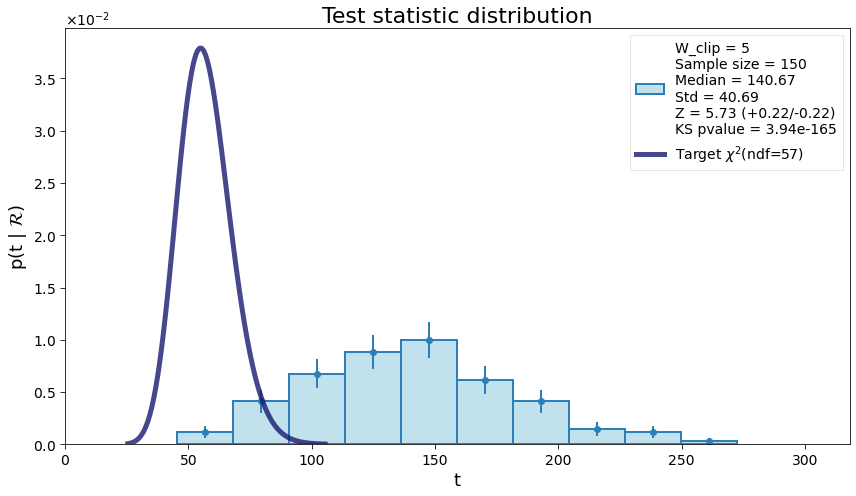

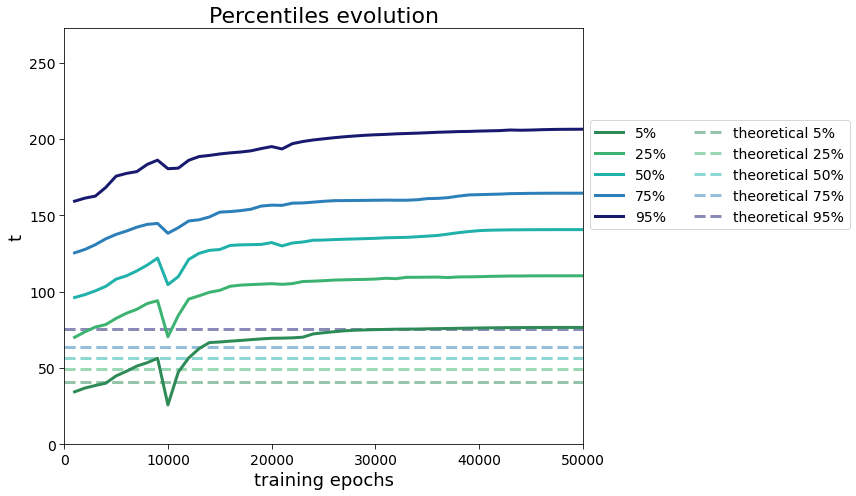

In [5]:
SAVE = False

save_path = f"./plots/{DATA_RUN}_{DATA_SUFFIX}/"

file_name   = f"Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
file_name  += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
file_name  += f"_wclip{WEIGHT_CLIPPING}"

if not os.path.exists(save_path):
        os.makedirs(save_path)

modules.analysis_utils.plot_1distribution(
    t=tau, 
    df=dof, 
    xmin=None, 
    xmax=None, 
    nbins=10, 
    wclip=WEIGHT_CLIPPING, 
    save=SAVE, 
    save_path=save_path, 
    file_name=file_name
)
modules.analysis_utils.plot_percentiles(
    tvalues_check=tau_history, 
    df=dof, 
    patience=1000, 
    ymin=0, 
    ymax=None, 
    wclip=WEIGHT_CLIPPING, 
    smooth=True, 
    save=SAVE,
    save_path=save_path, 
    file_name=file_name
)

## Reco

In [55]:
reference = read_data(file_name=DATA_FOLDER+REFERENCE_FILE, theta1=0, theta2=55)
data      = read_data(file_name=DATA_FOLDER+DATA_FILE, theta1=0, theta2=55)

print(reference.shape)
print(data.shape)

N_D = data.shape[0]
N_R = reference.shape[0]

weightsData = np.ones(data.shape[0])
weightsRef  = np.ones(reference.shape[0])*N_D*1./N_R

dt_bins = np.linspace(-90, 490, 100)
th_bins = np.linspace(-55,  55, 100)

bins_code={"drift_time":dt_bins,"theta":th_bins}
xlabel_code={"drift_time":"drift time (ns)", "theta":"theta (deg)"}

(1013442, 2)
(464484, 2)


In [46]:
nn_par = modules.analysis_utils.collect_weights(DATA_IN_FOLDER)
model  = modules.analysis_utils.build_model(CONFIG_JSON)

dense_b
(150, 4)


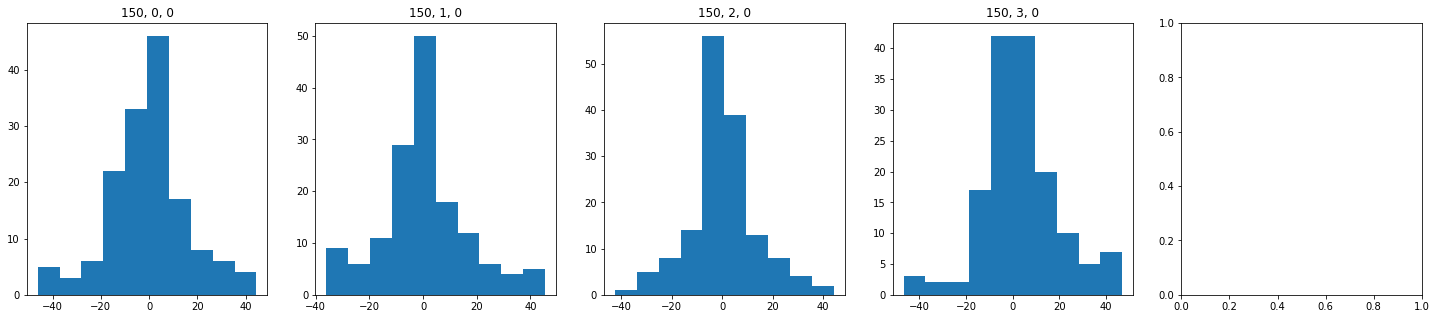

dense_k
(150, 2, 4)


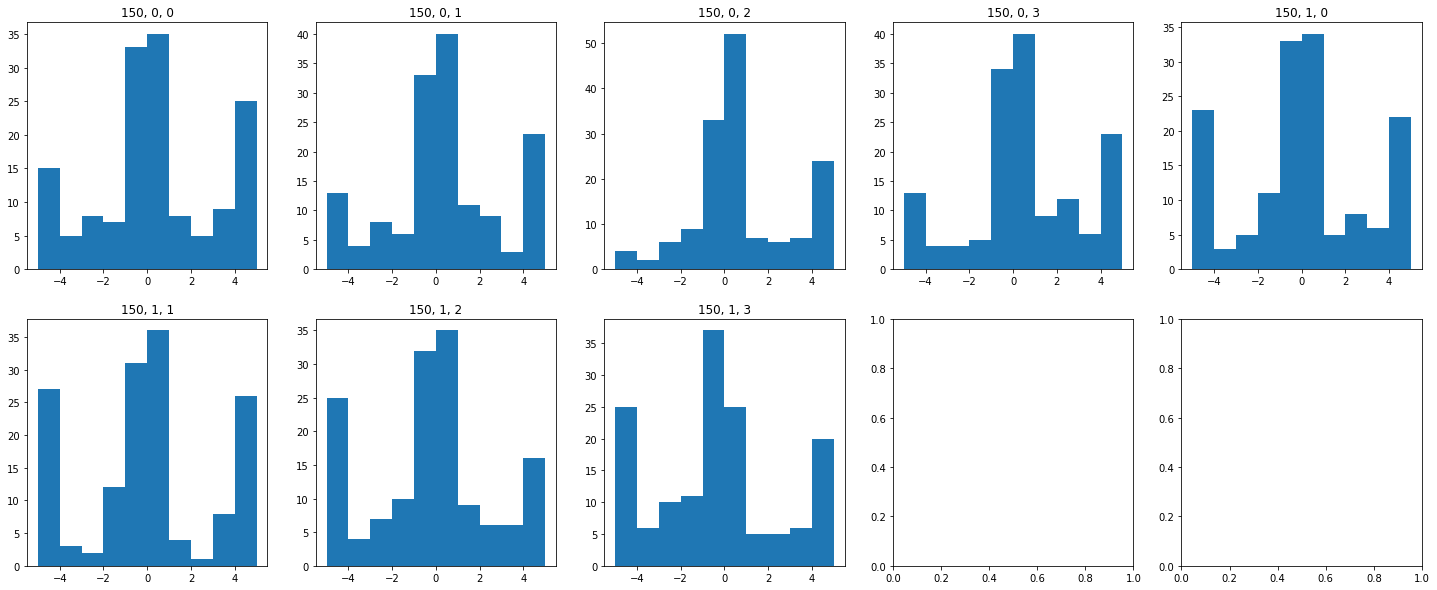

dense_1_b
(150, 4)


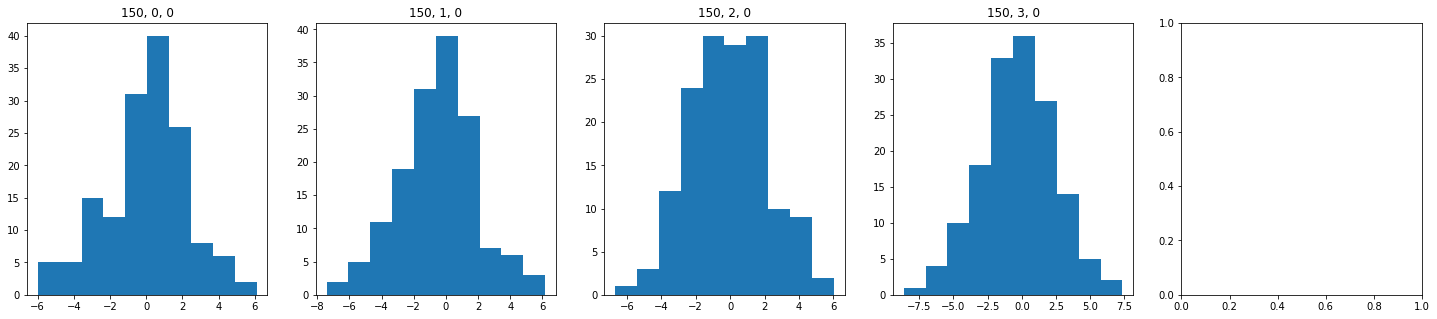

dense_1_k
(150, 4, 4)


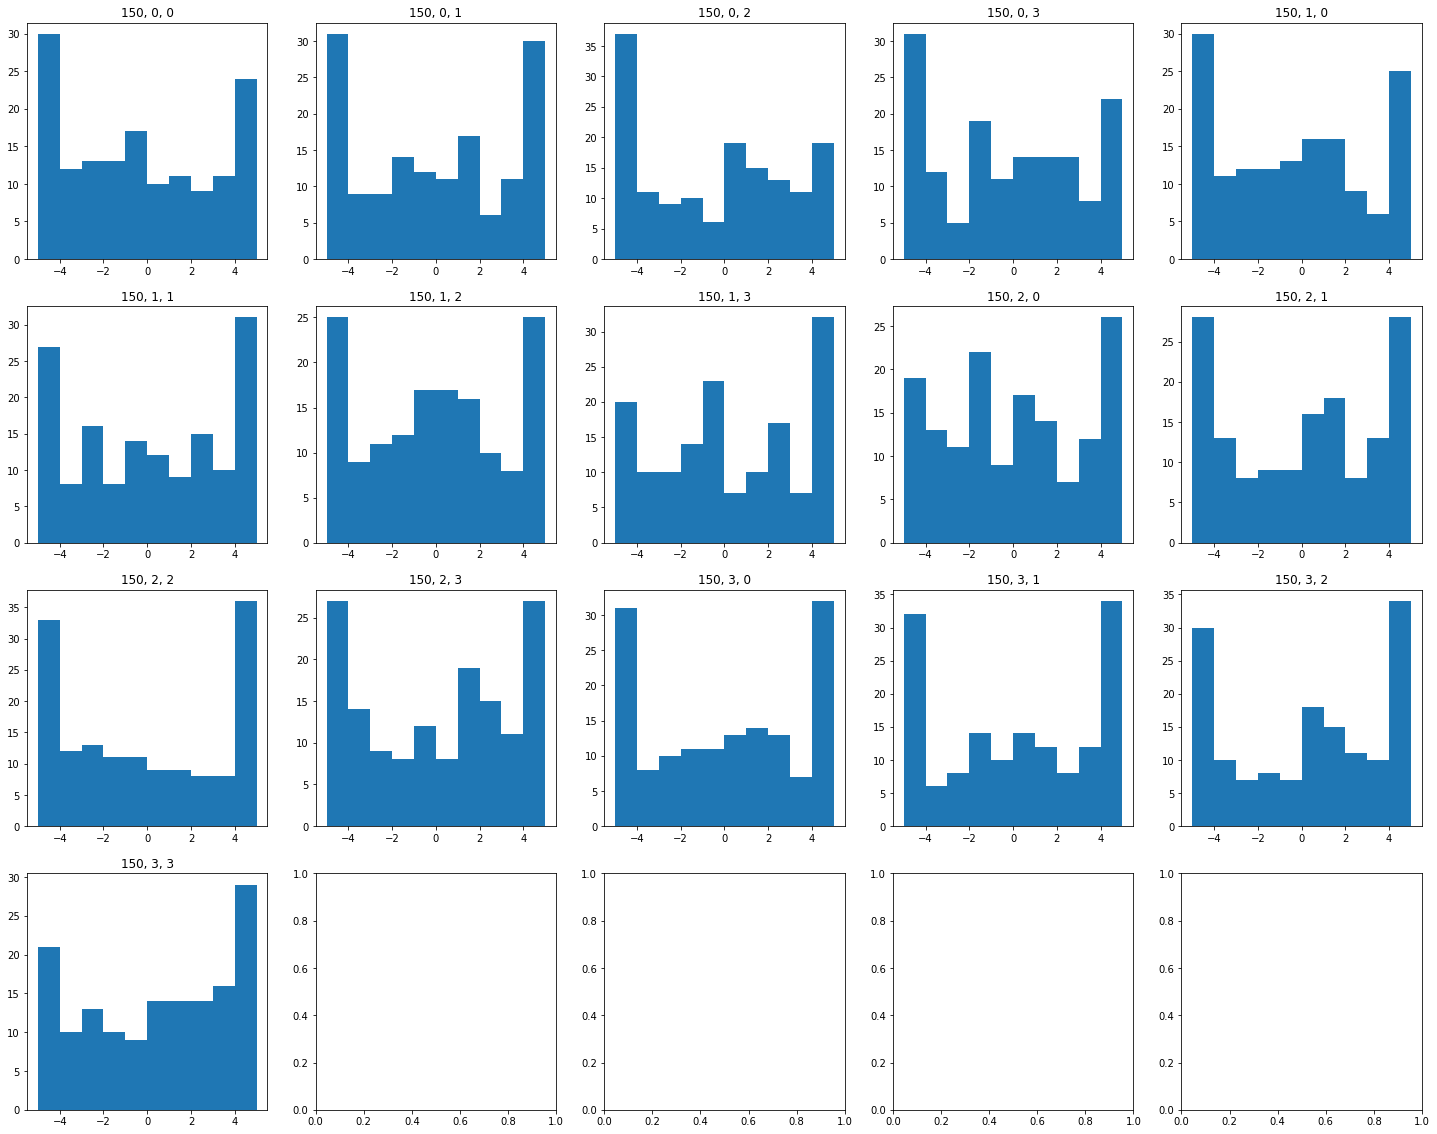

dense_2_b
(150, 4)


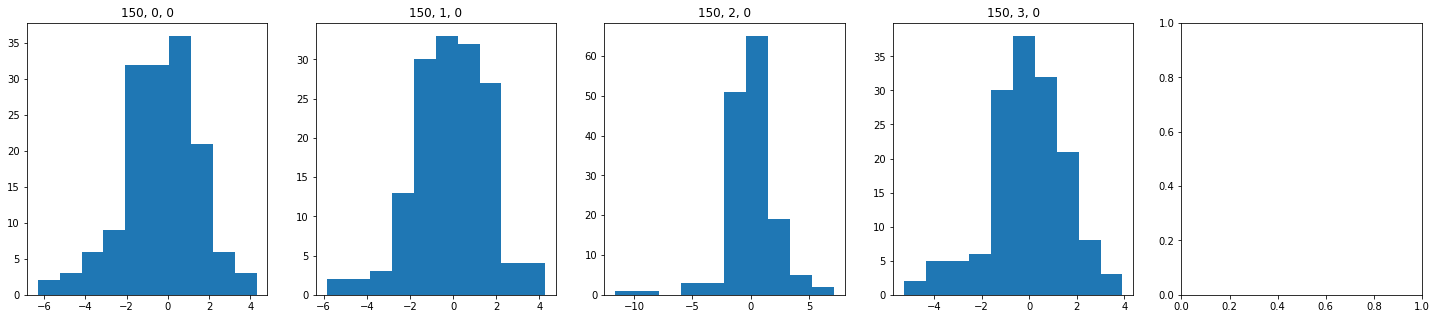

dense_2_k
(150, 4, 4)


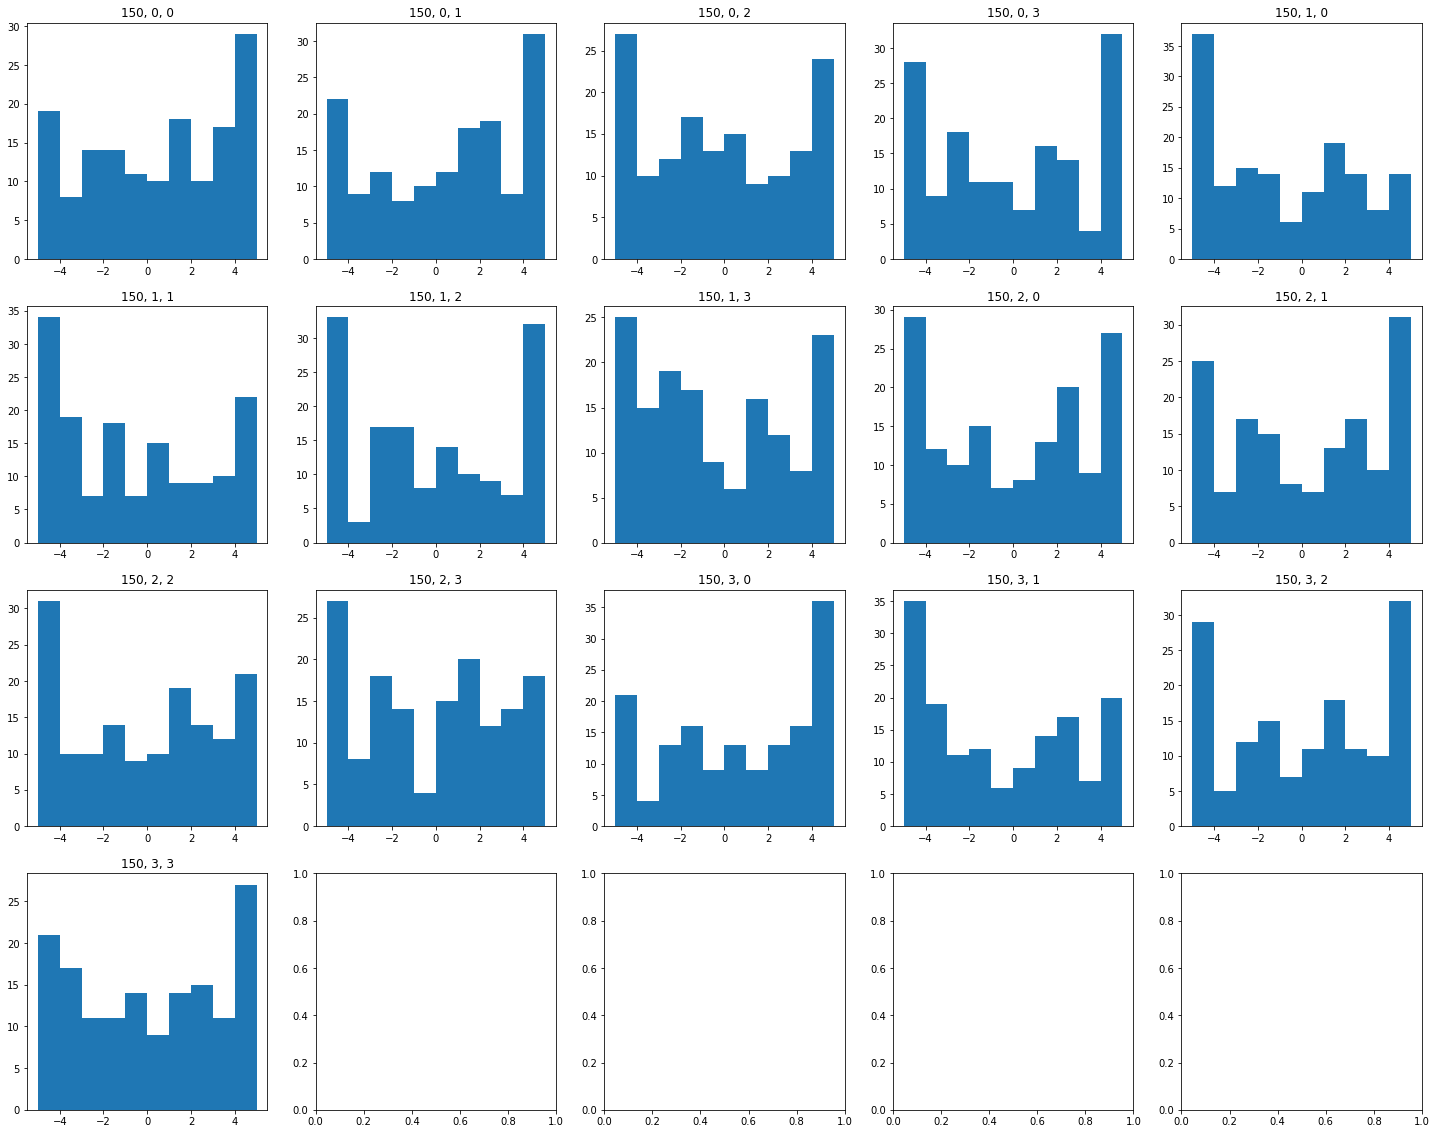

dense_3_b
(150, 1)


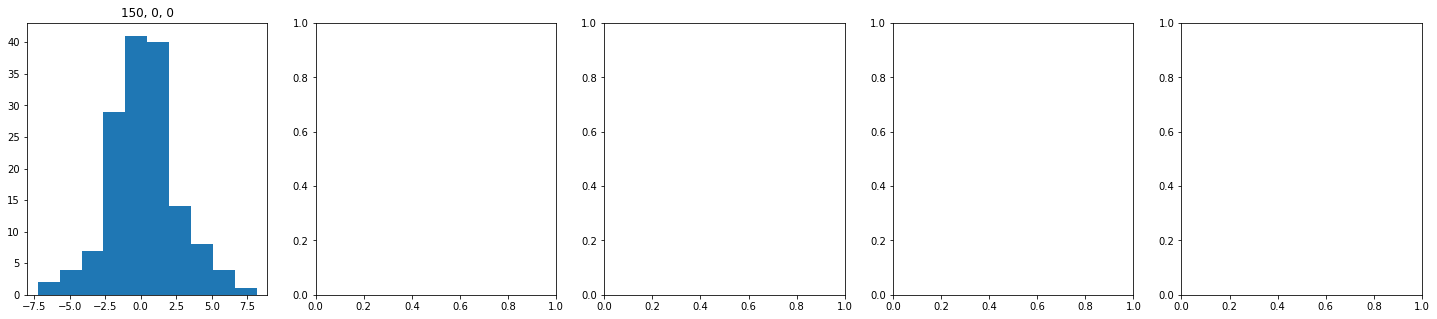

dense_3_k
(150, 4, 1)


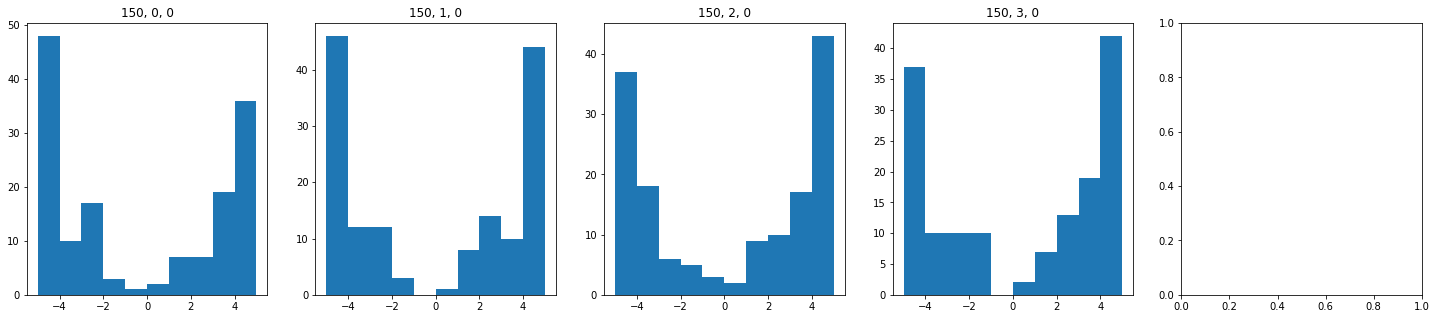

In [44]:
plot_weights_histograms(nn_par)

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


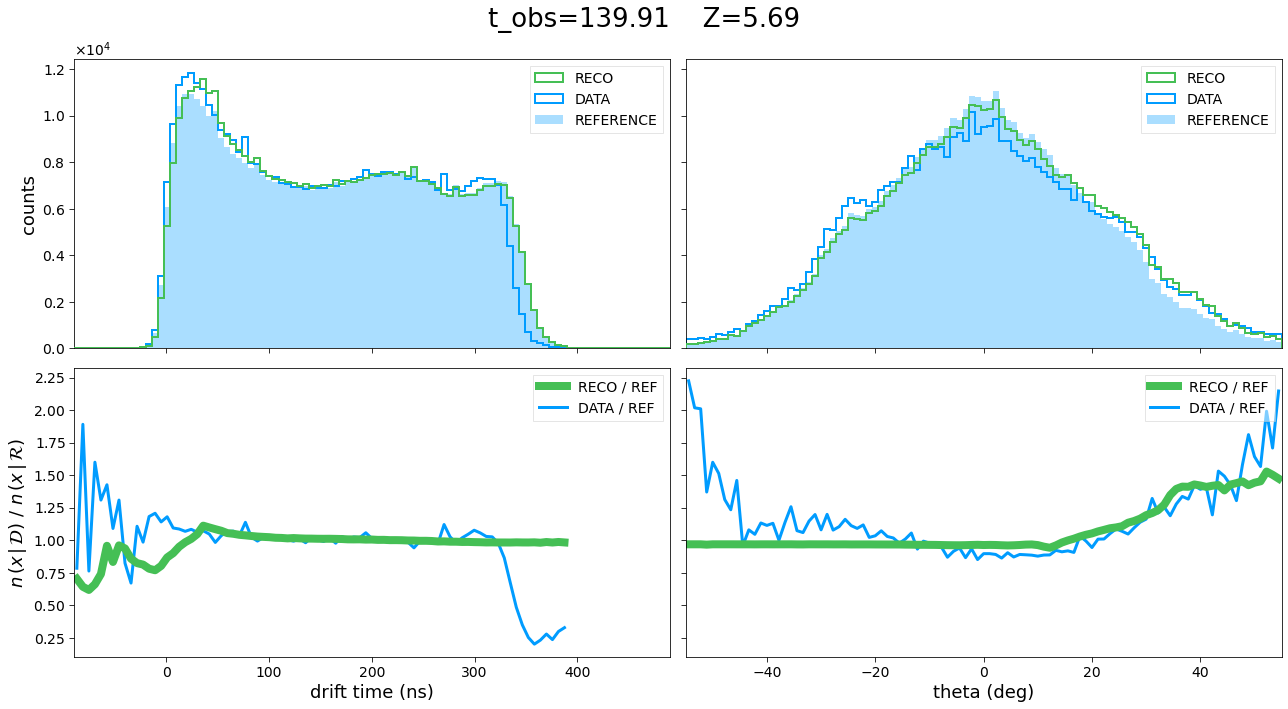

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


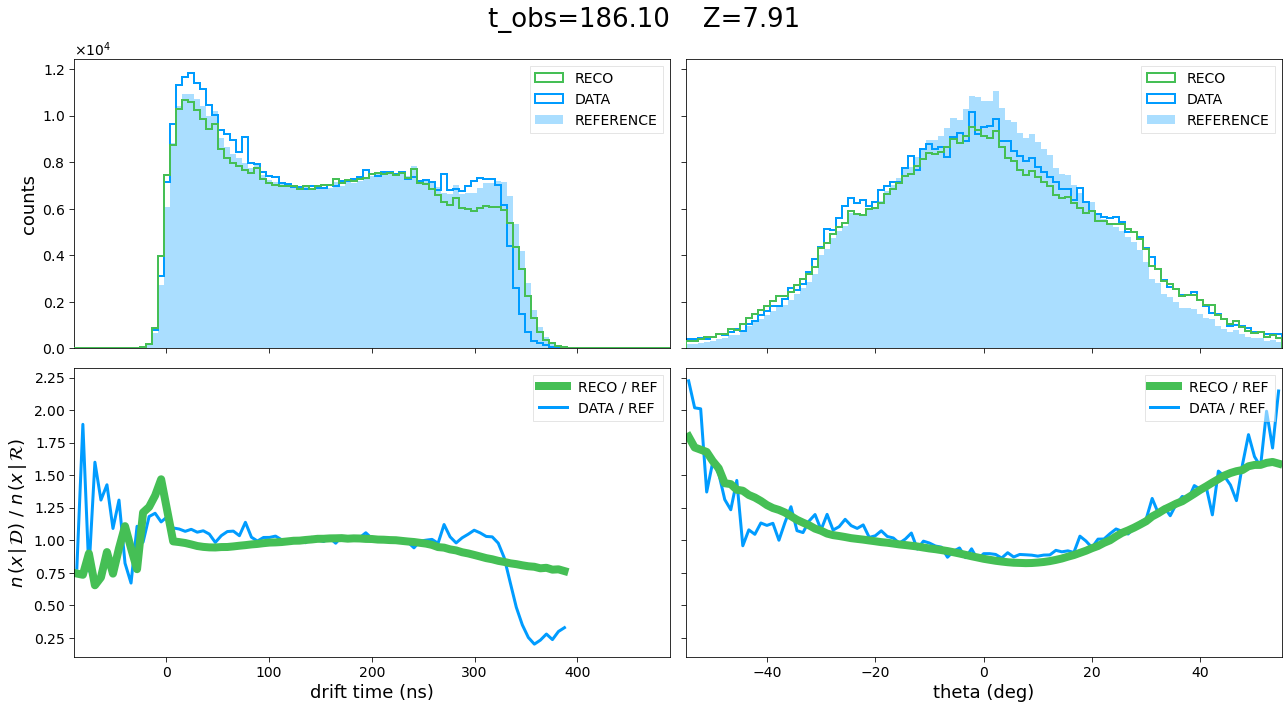

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


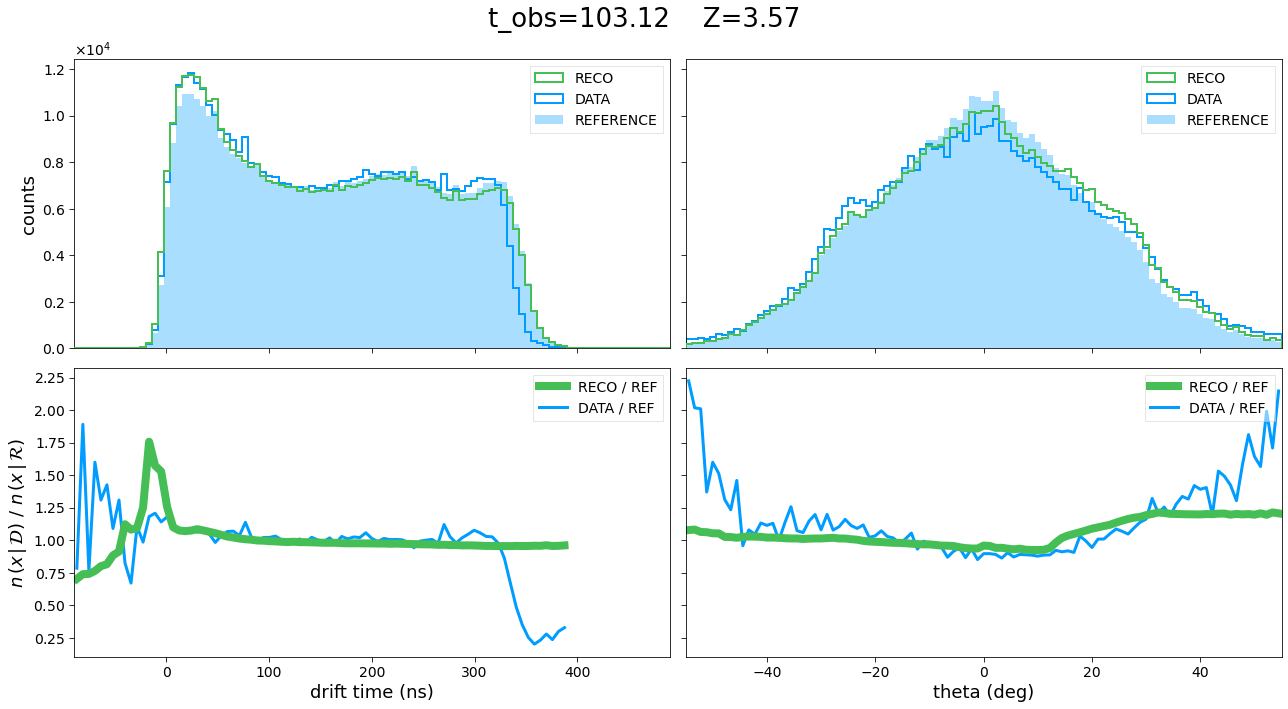

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


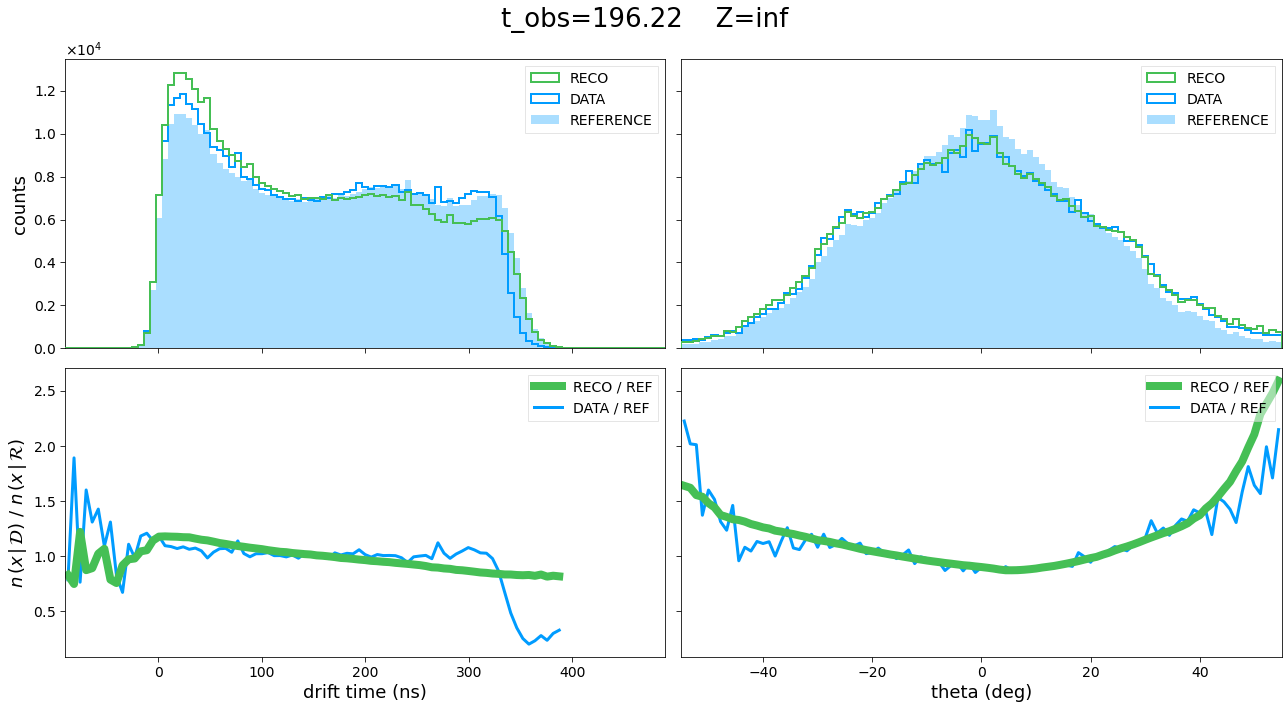

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


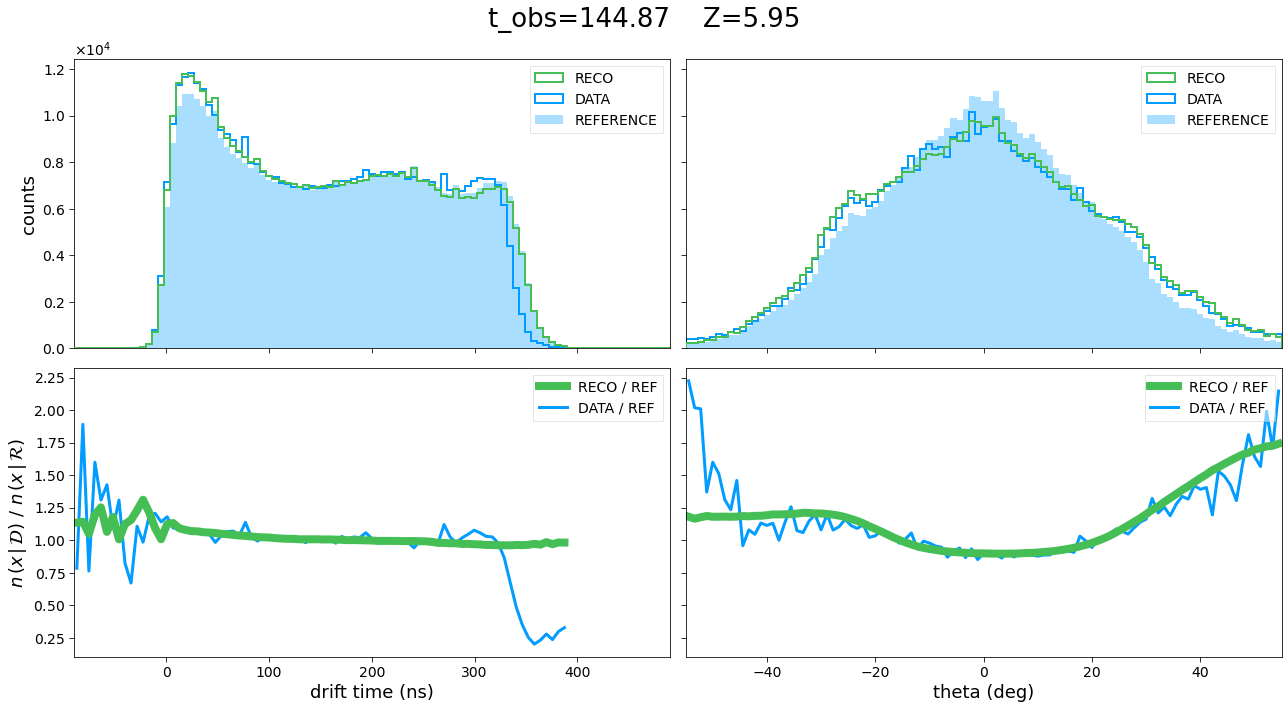

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


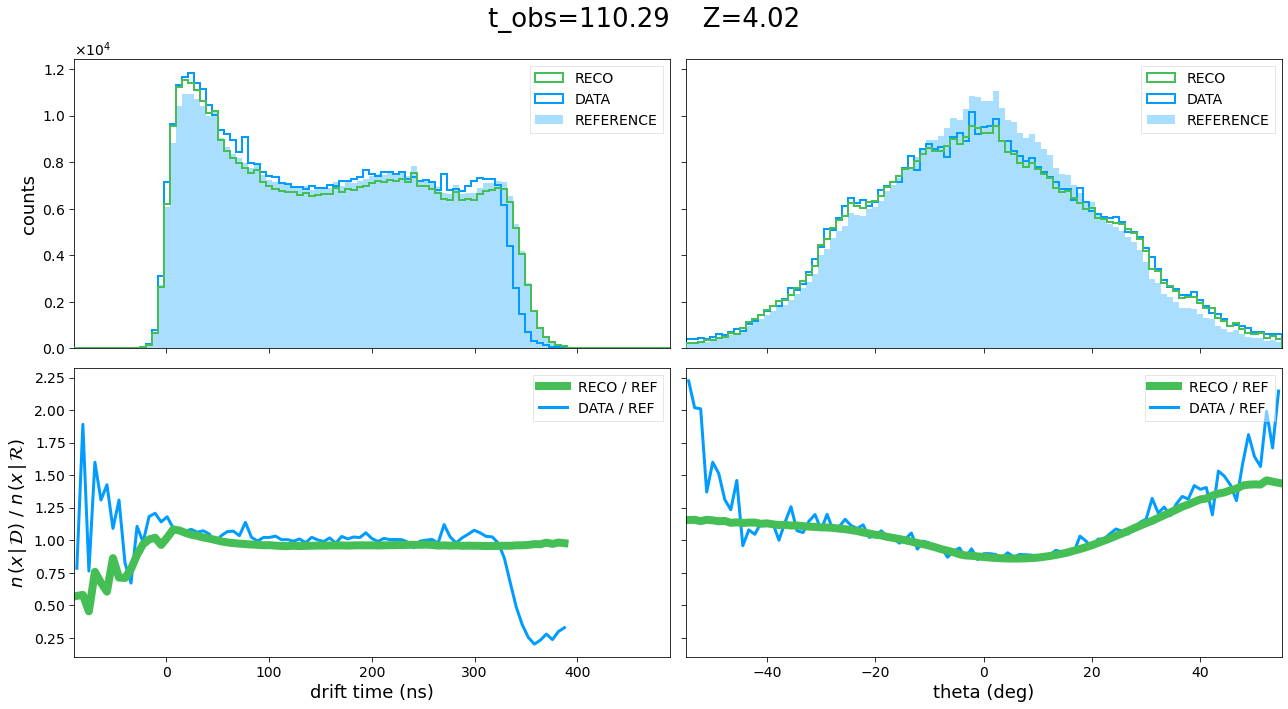

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


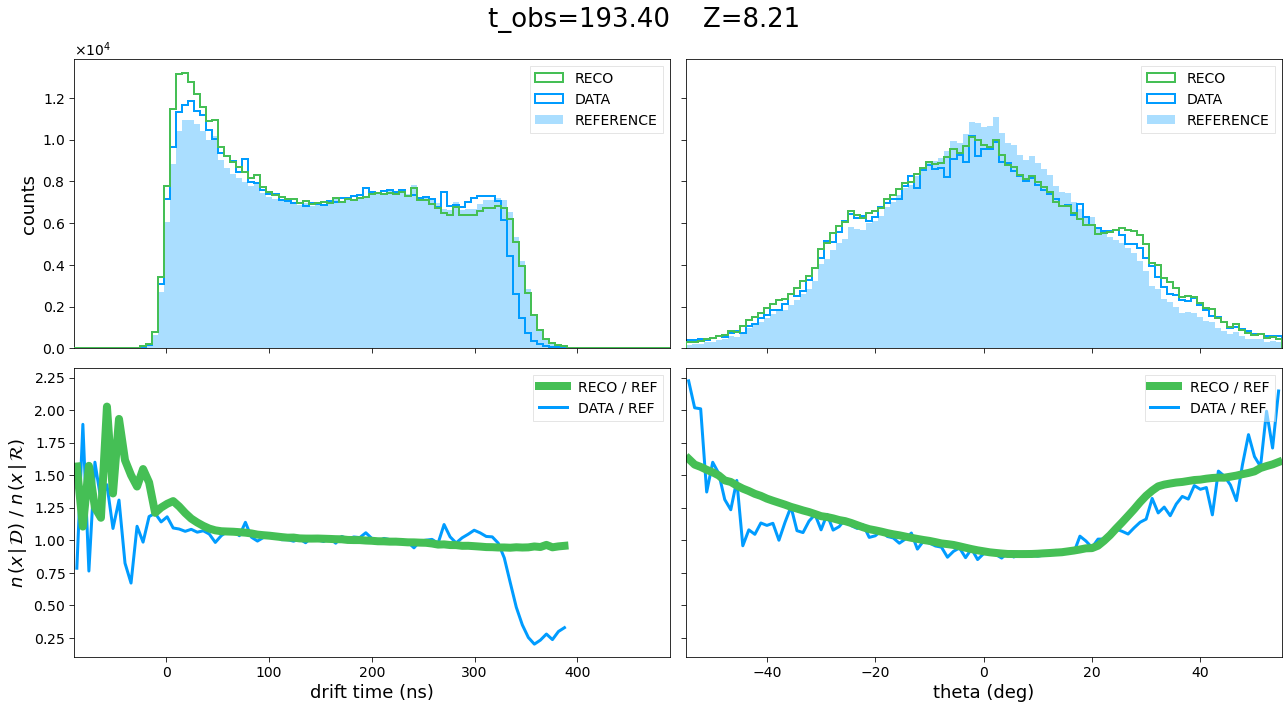

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


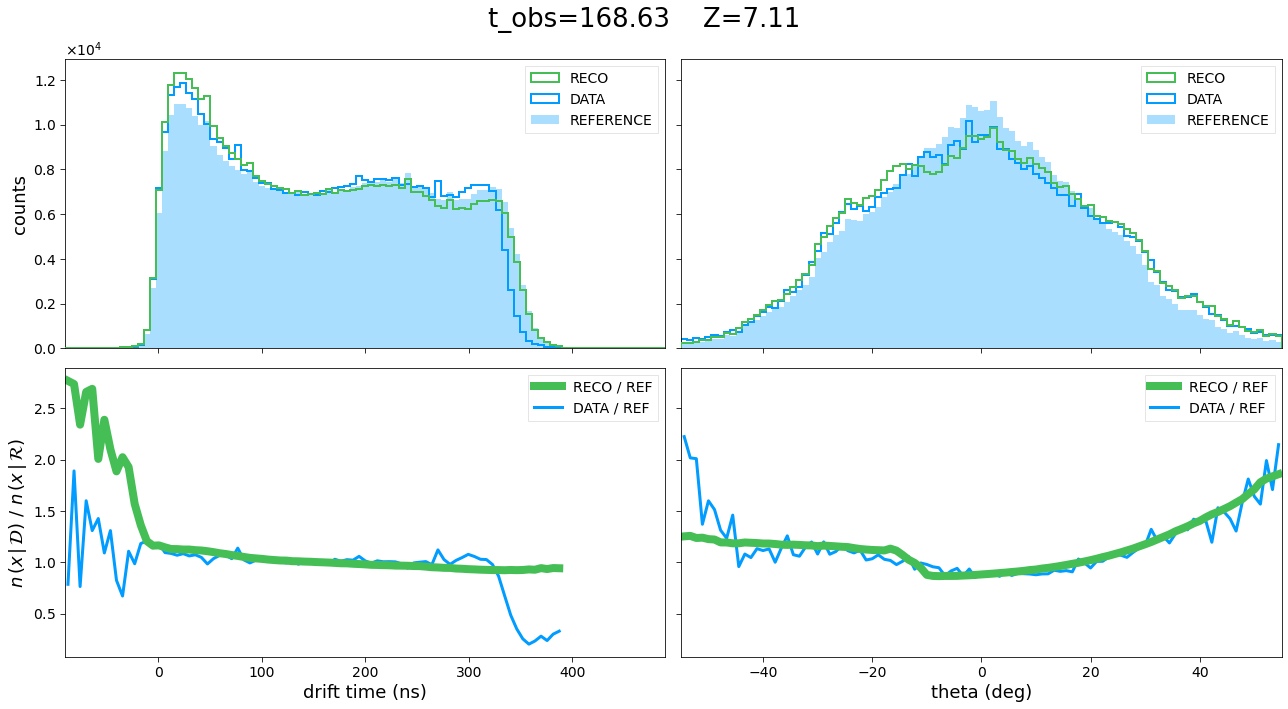

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


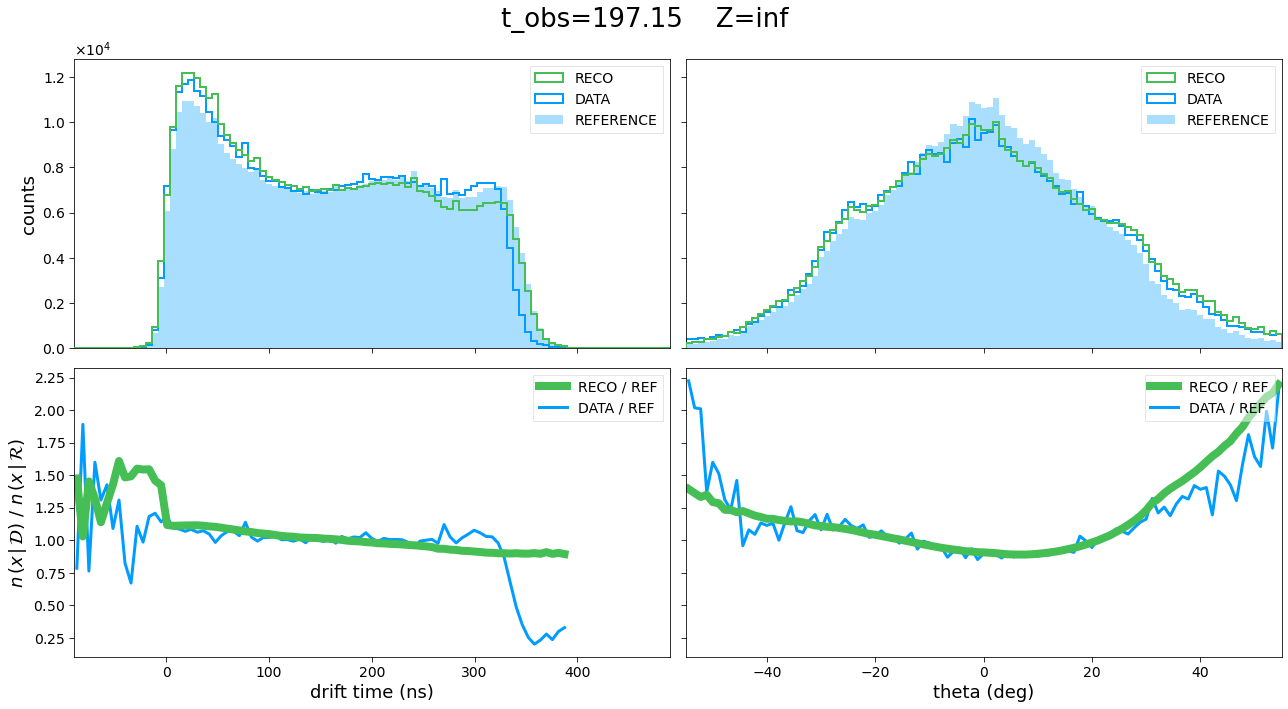

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


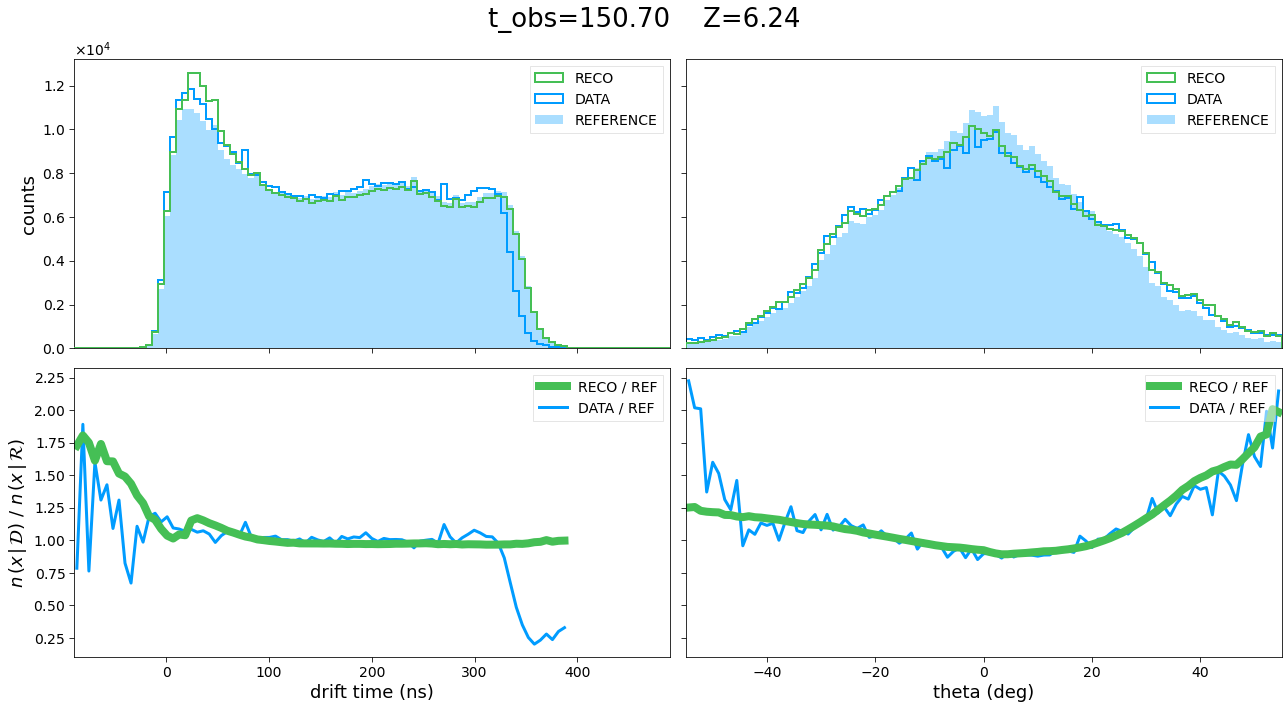

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


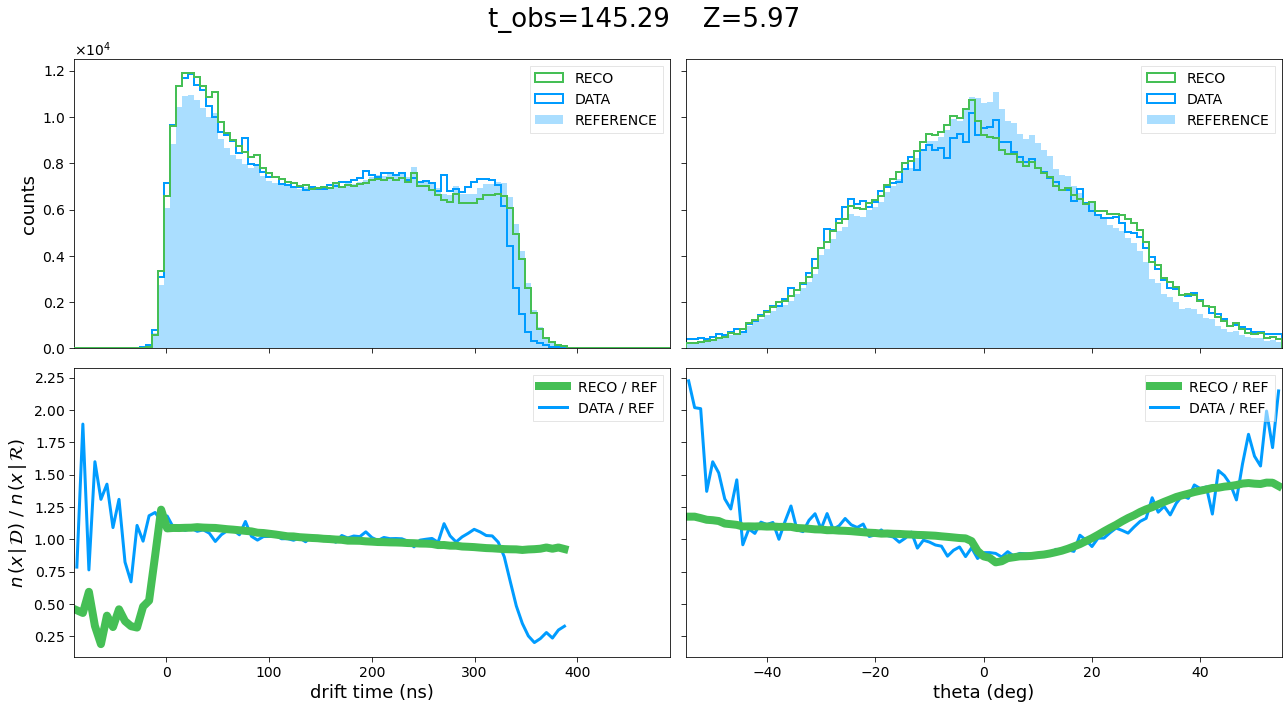

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


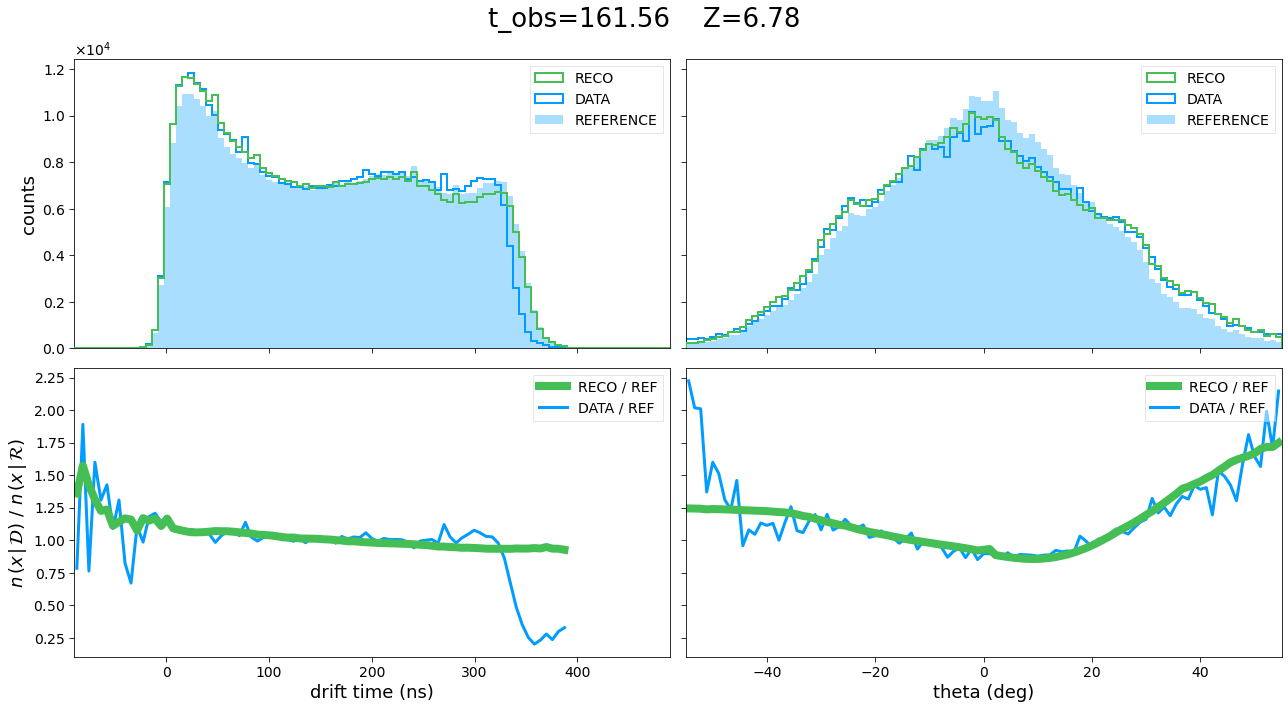

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


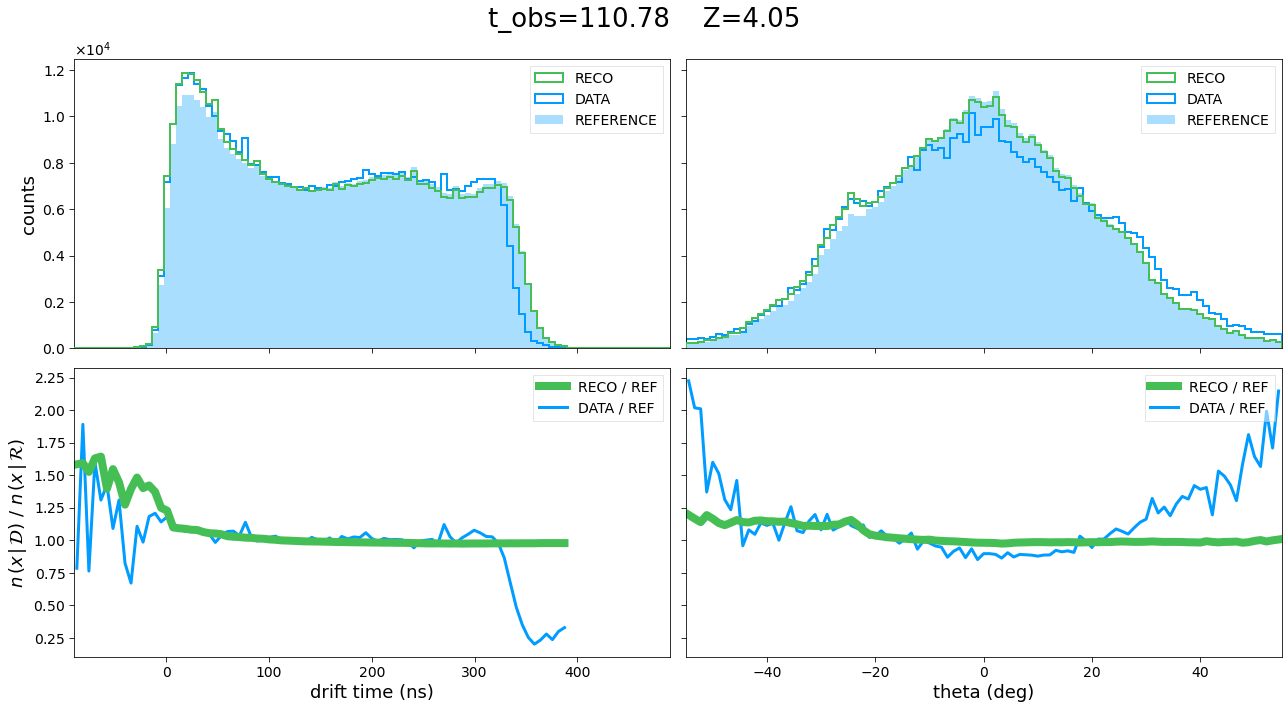

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


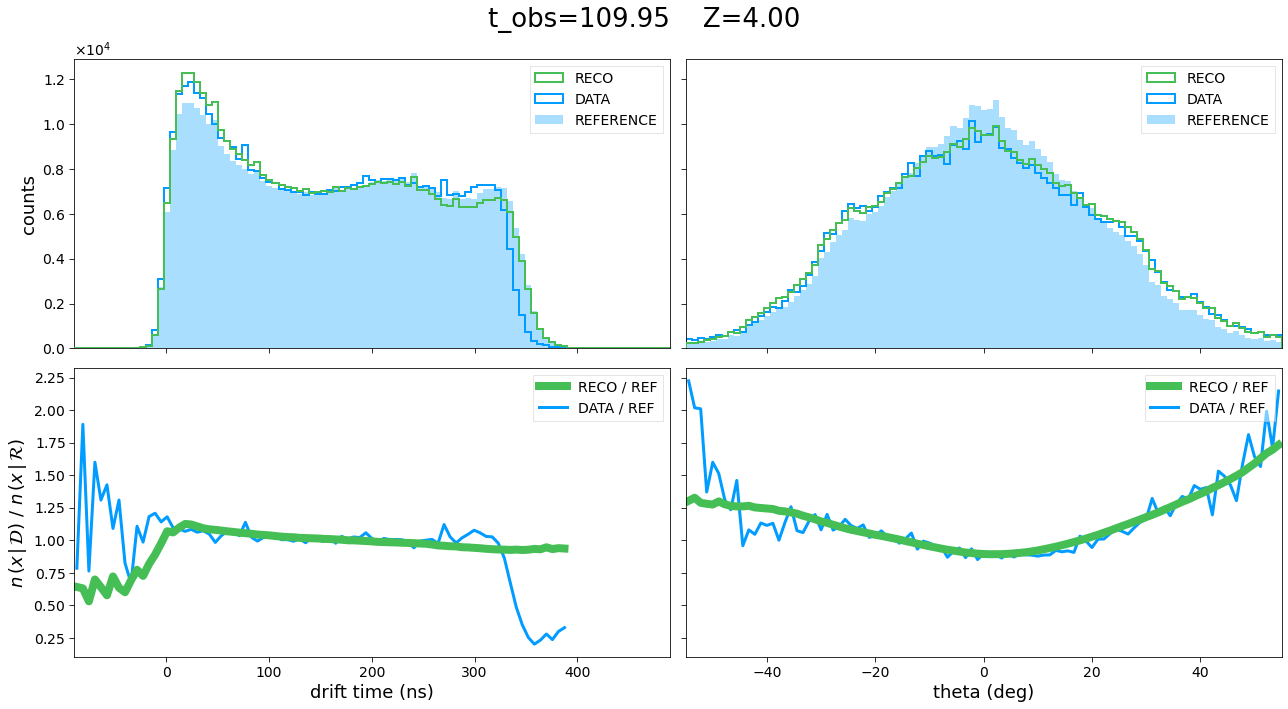

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


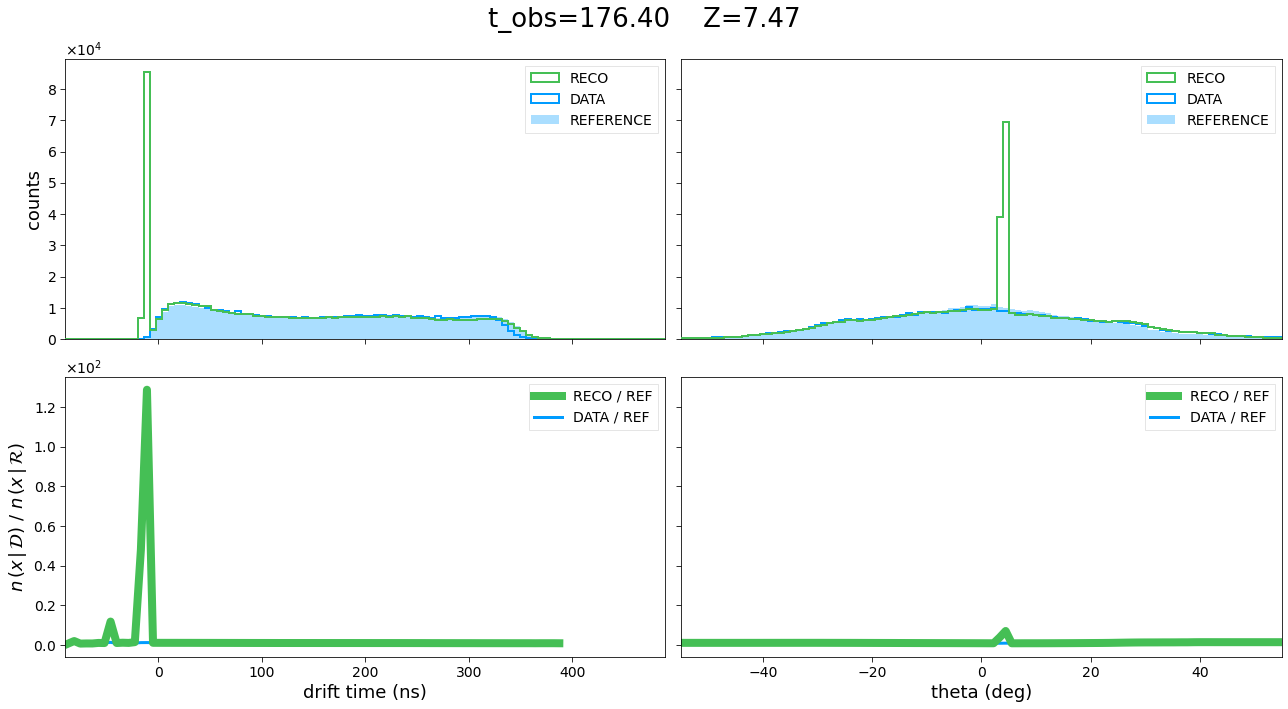

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


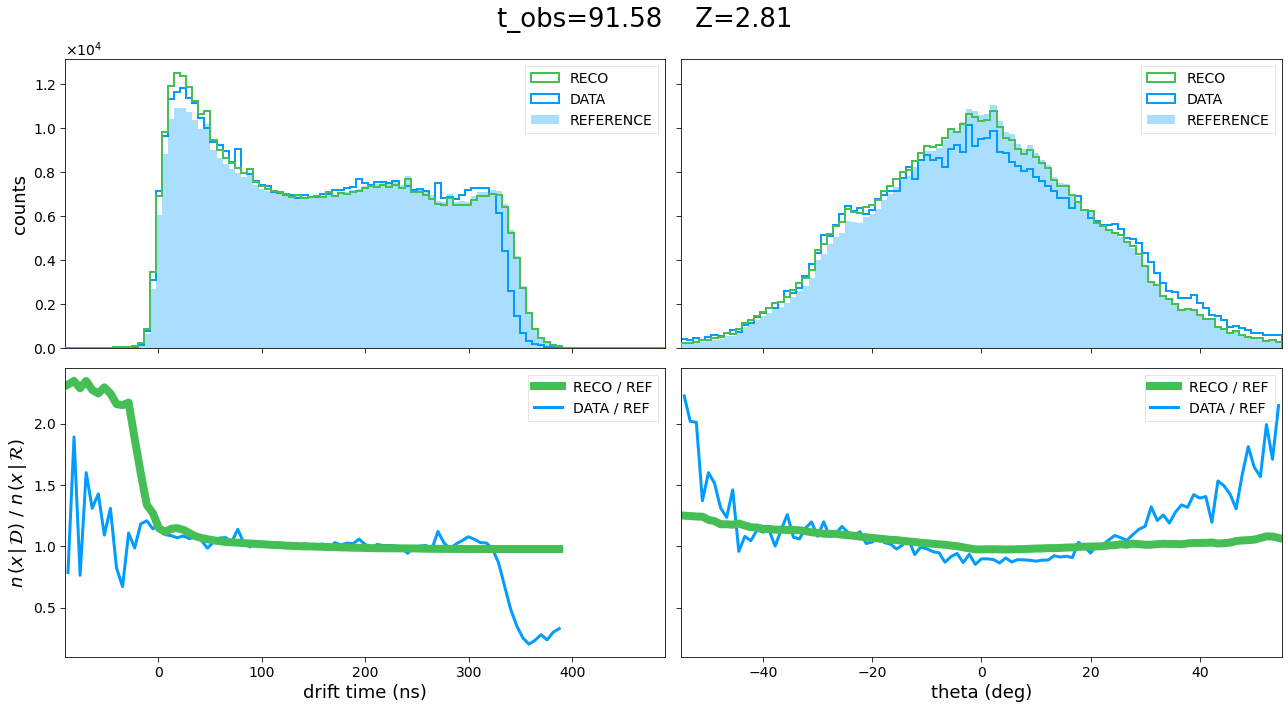

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


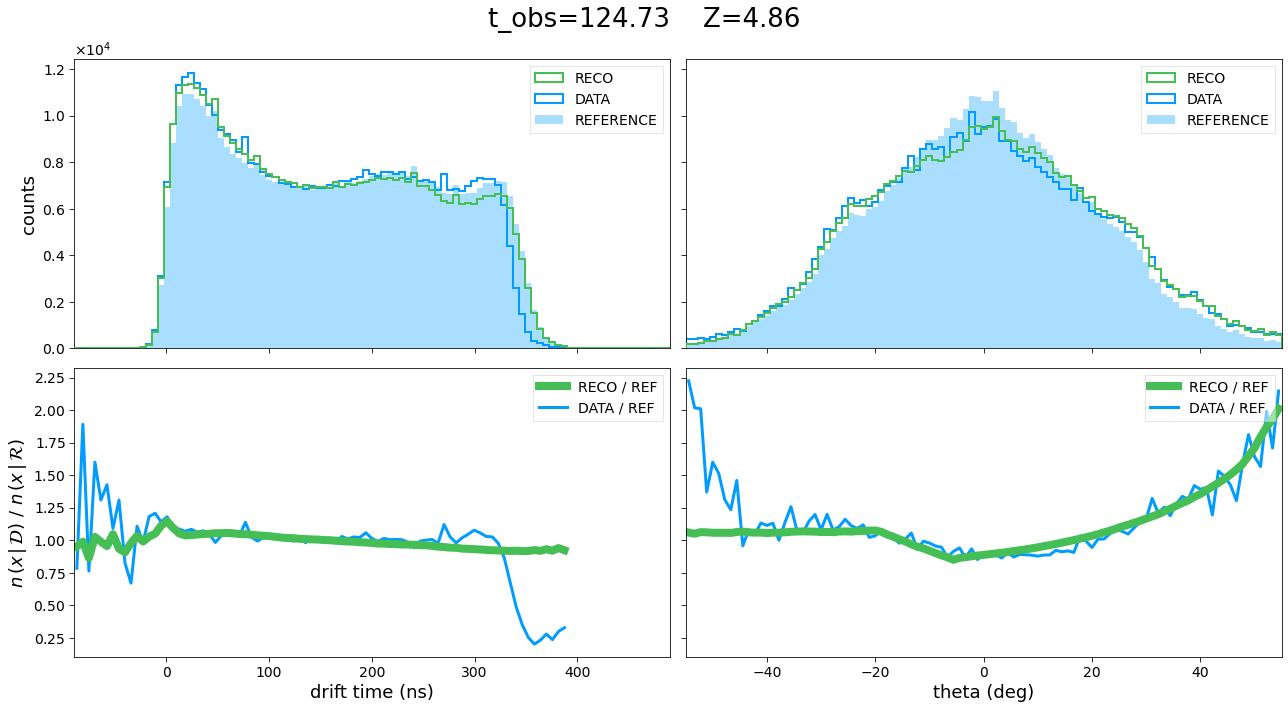

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


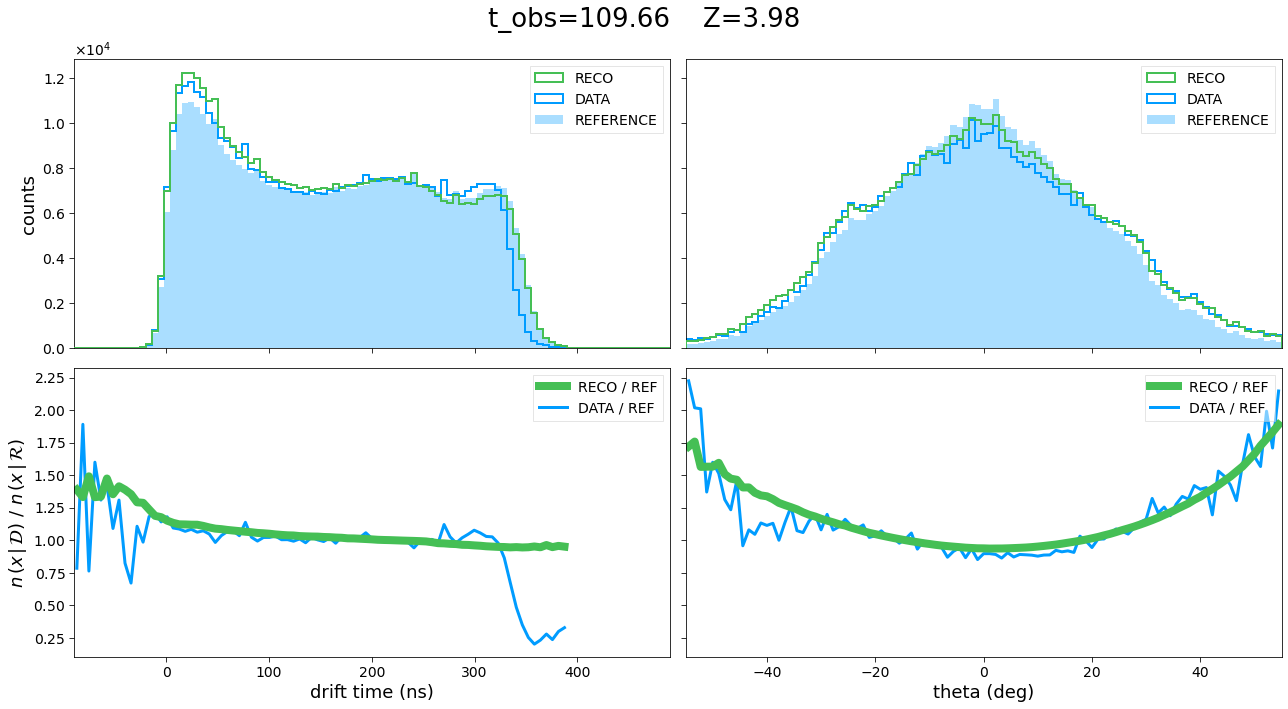

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


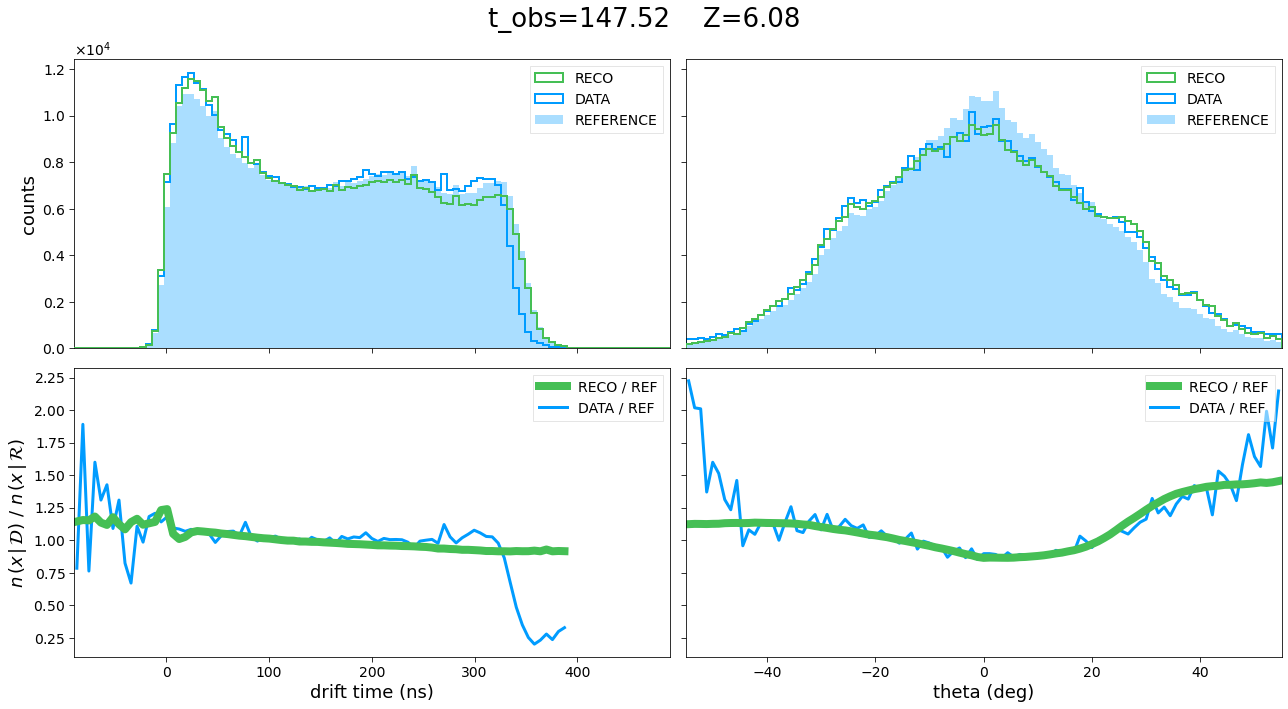

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


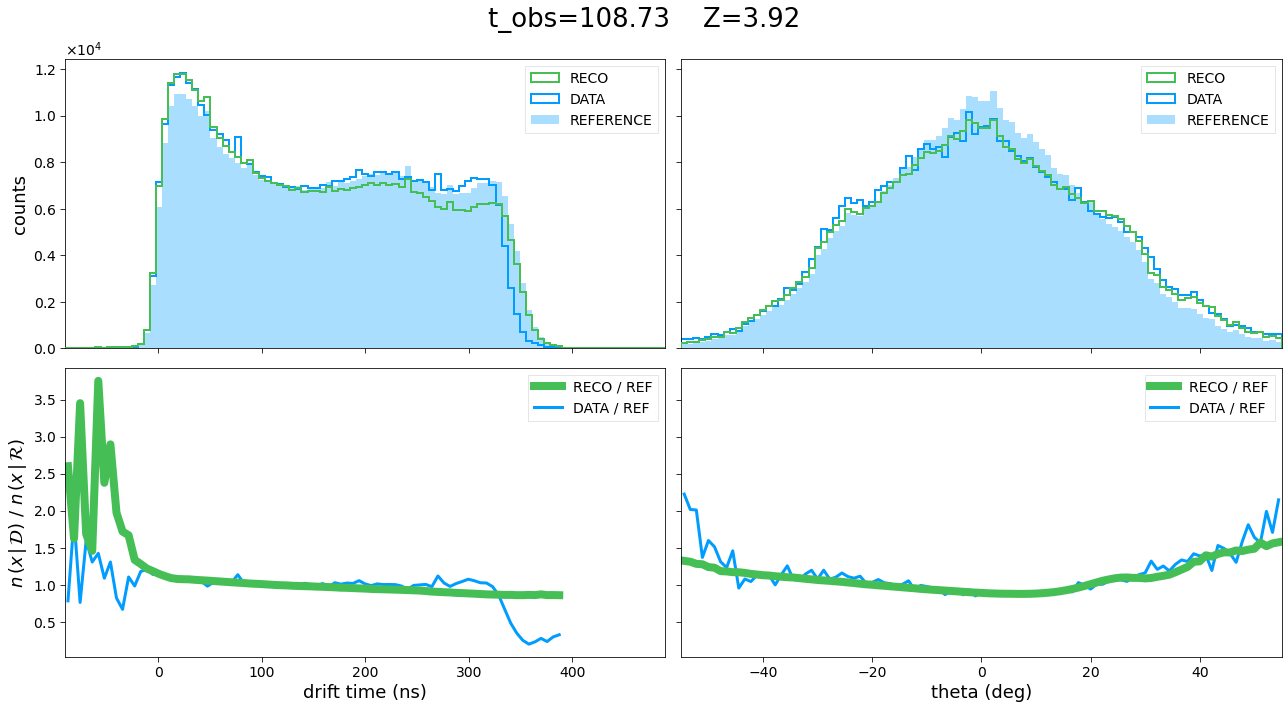

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


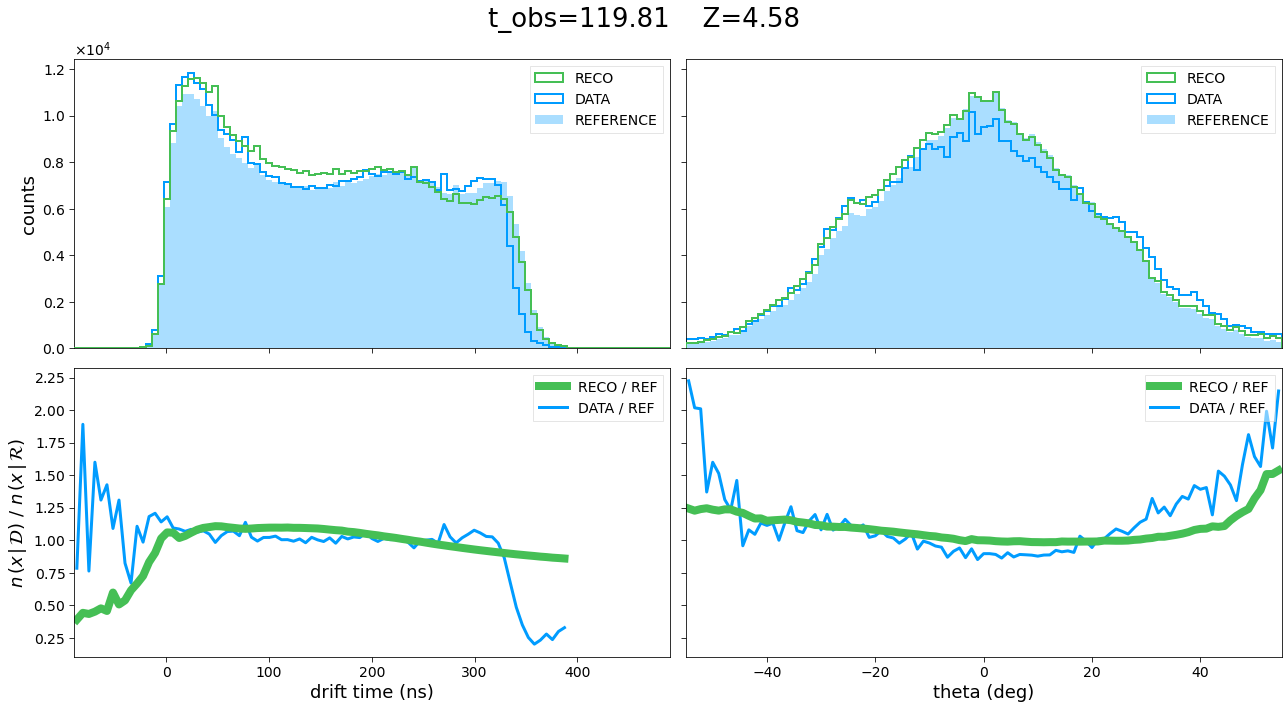

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


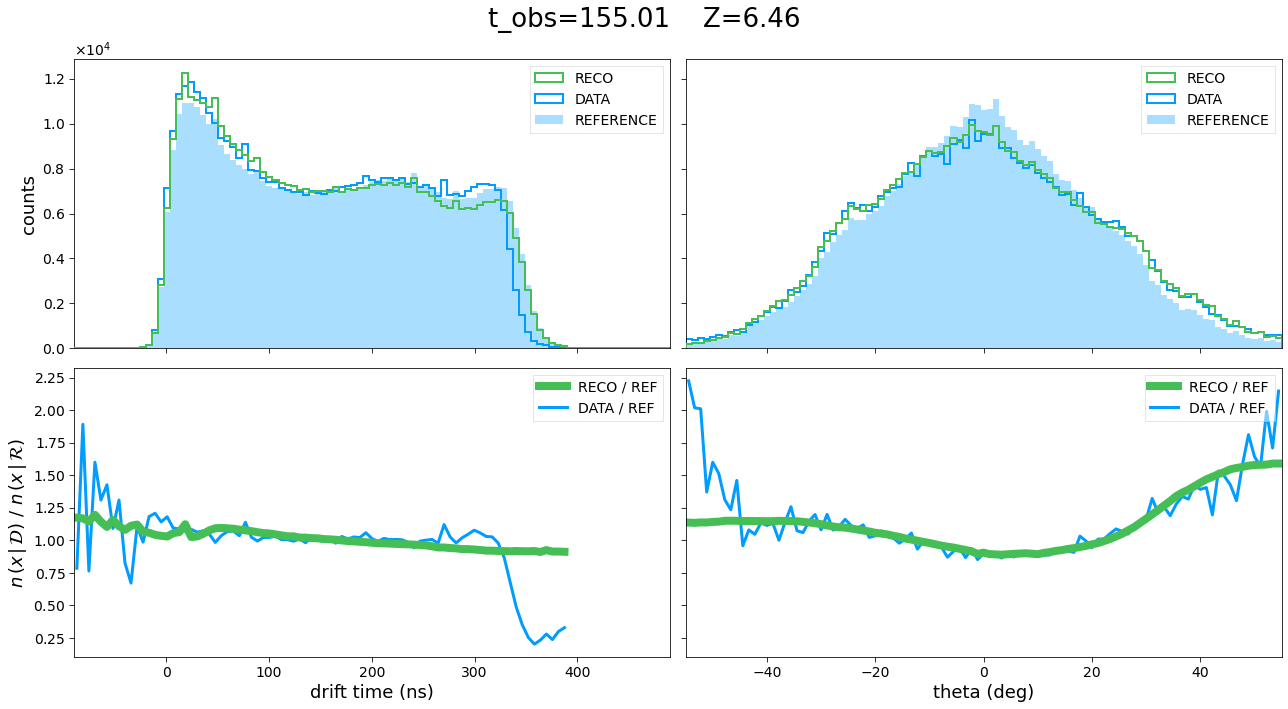

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


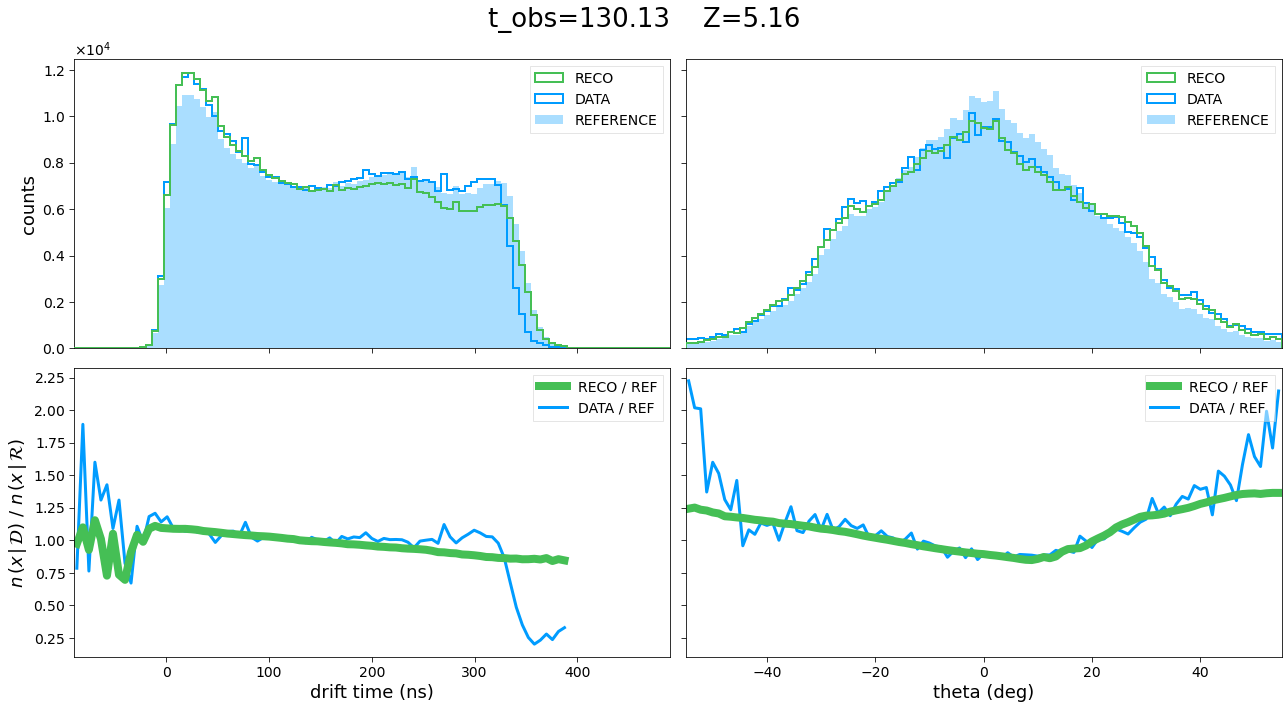

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


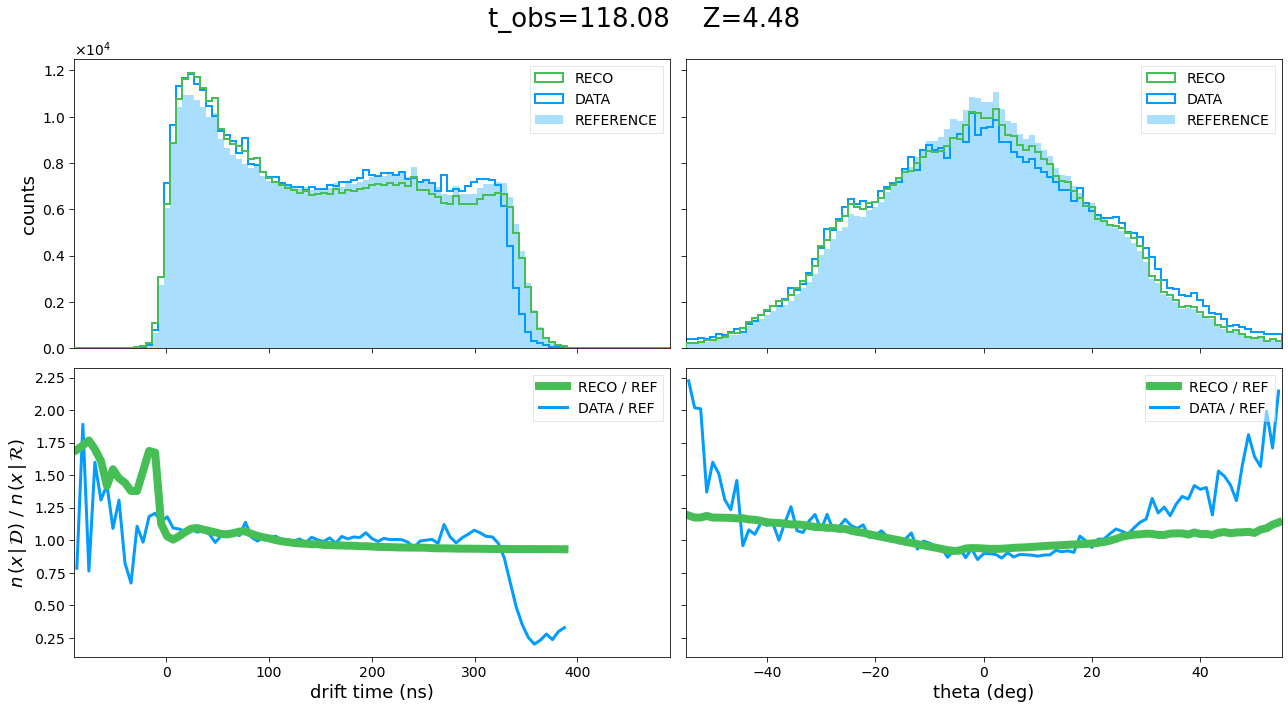

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


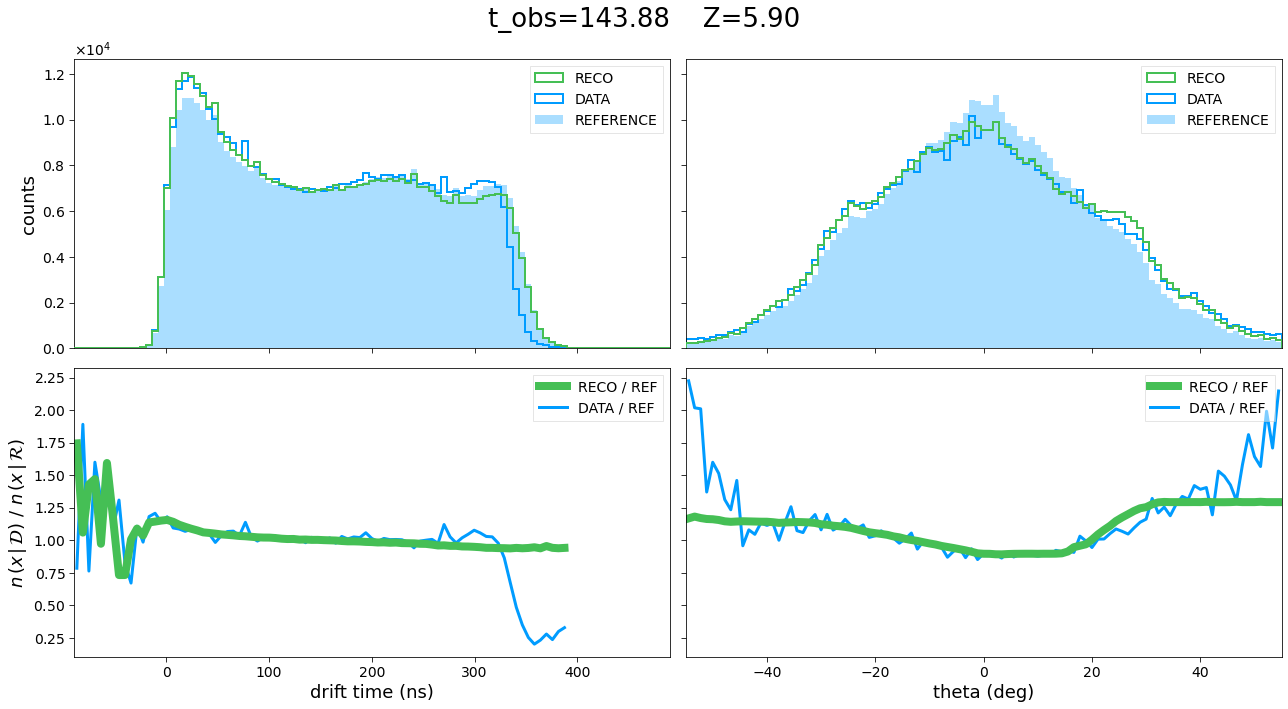

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


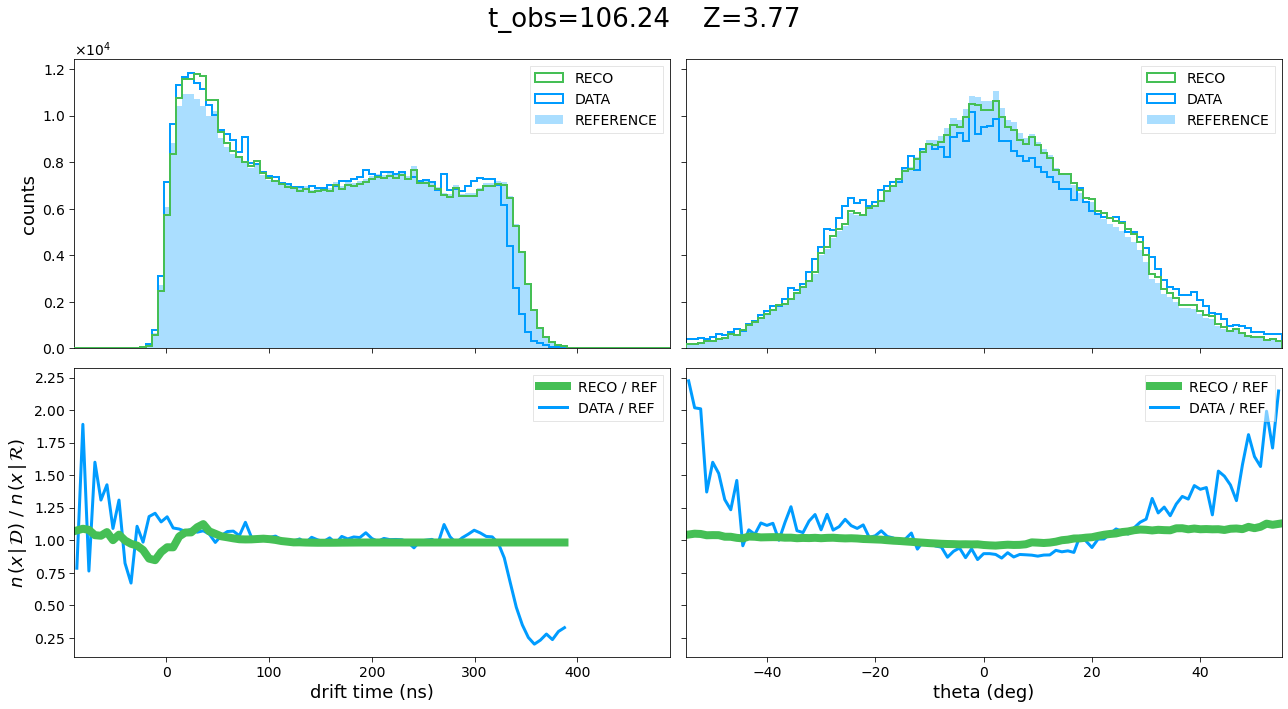

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


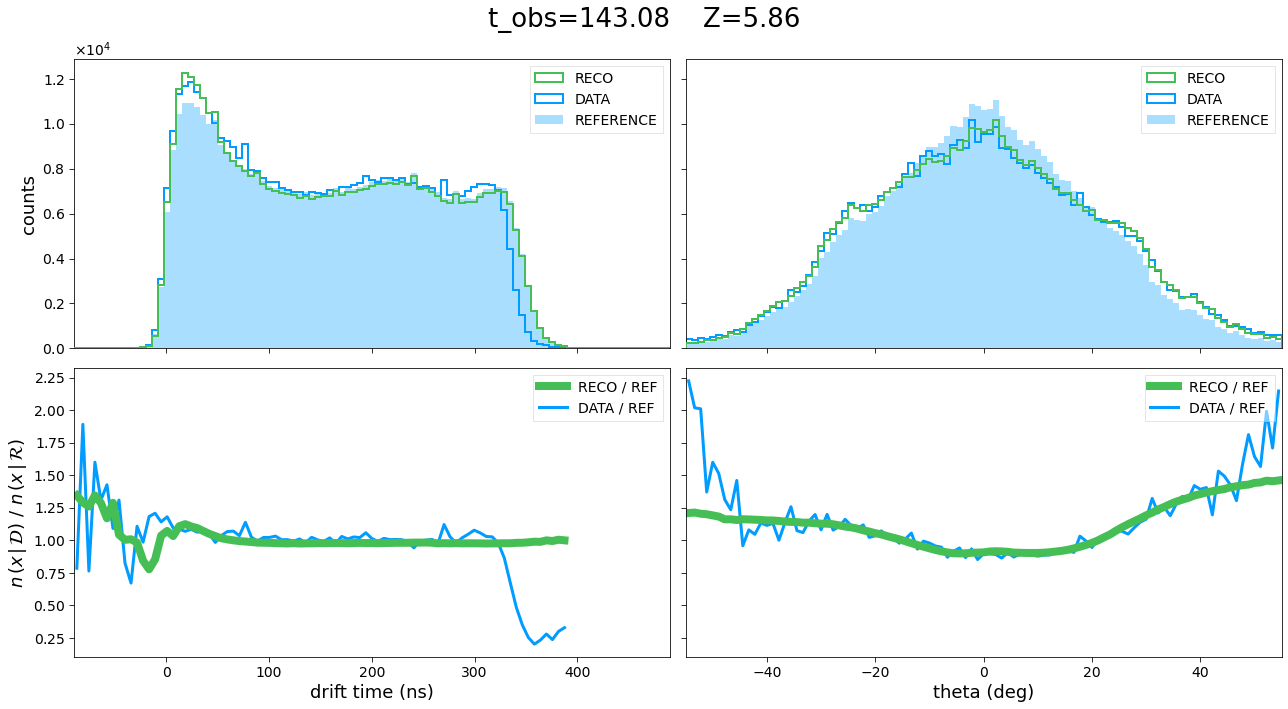

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


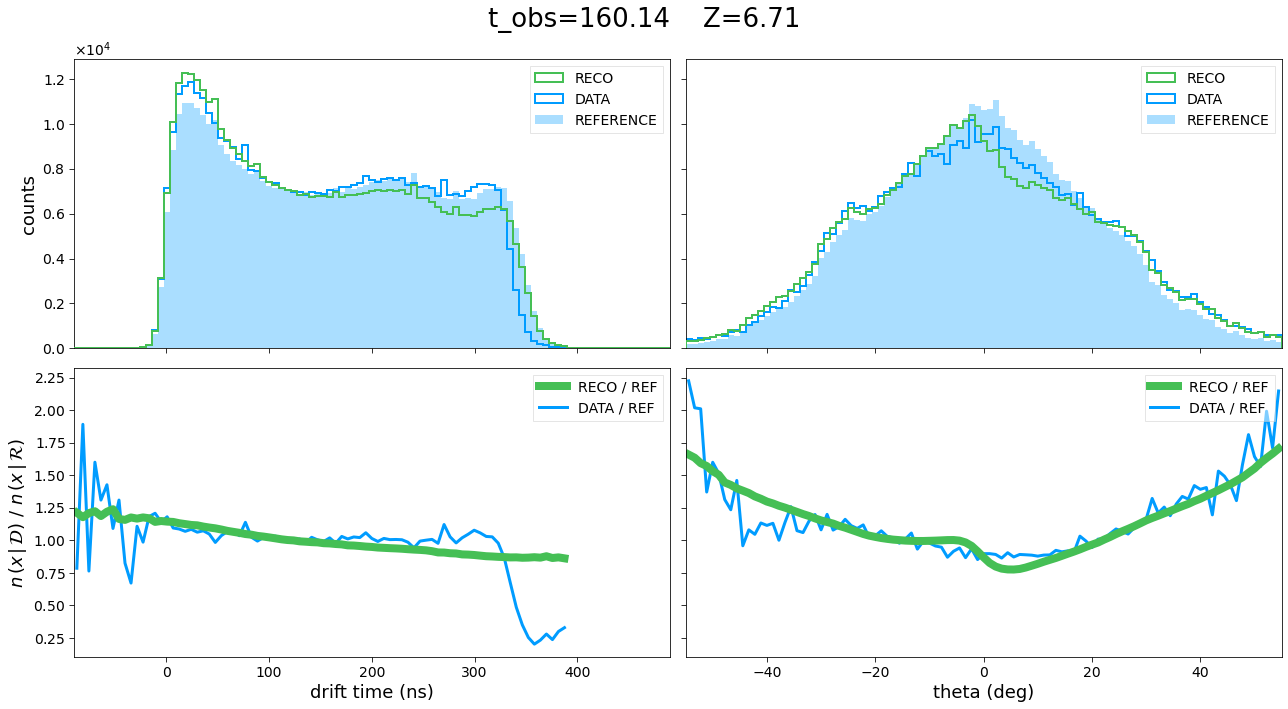

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


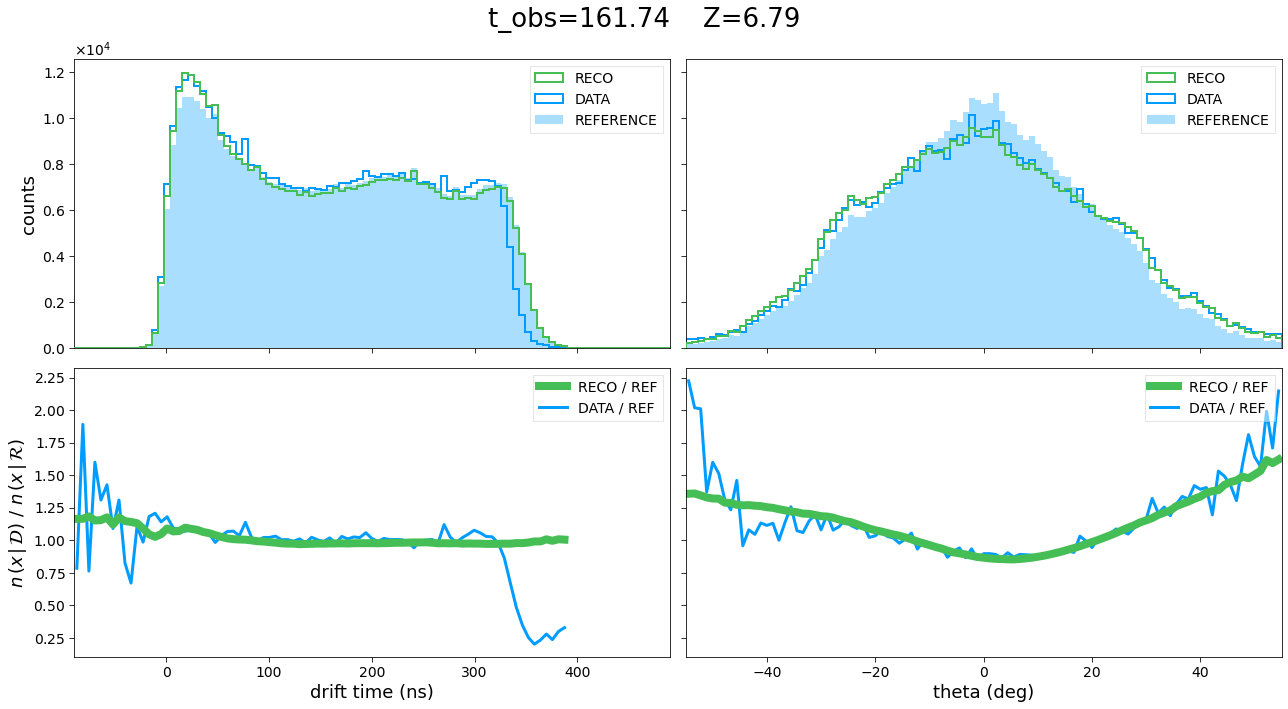

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


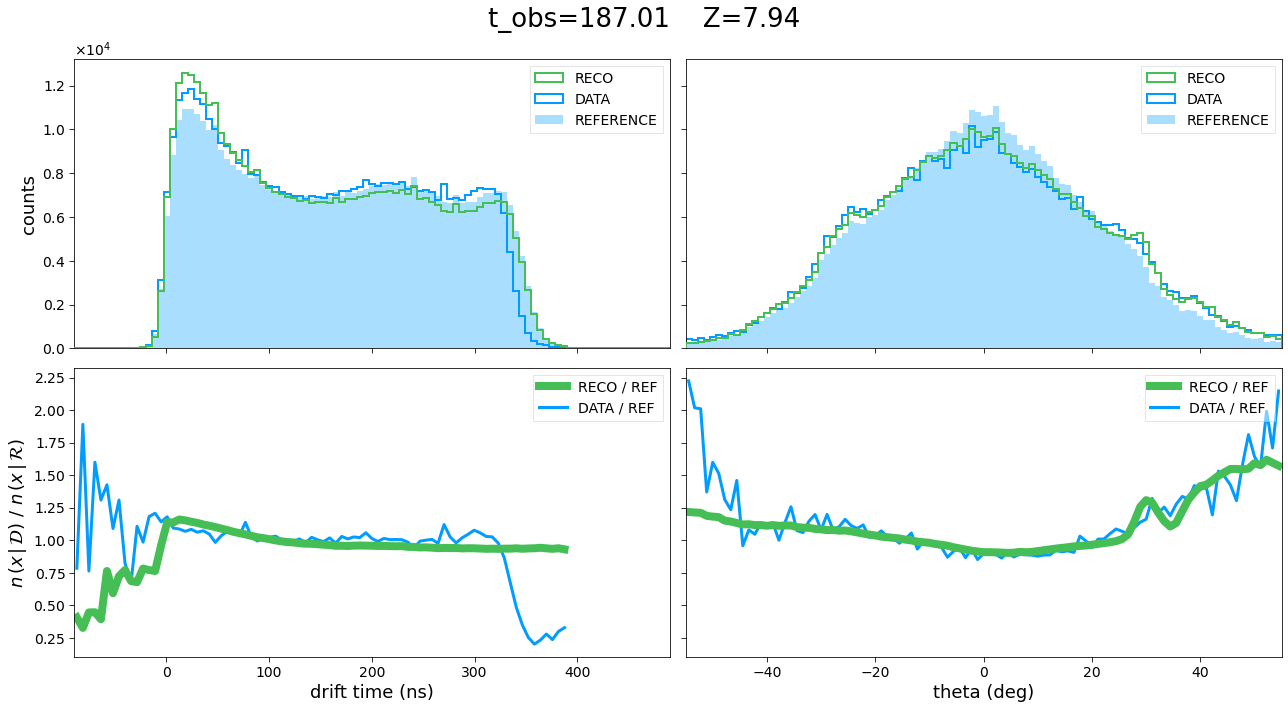

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


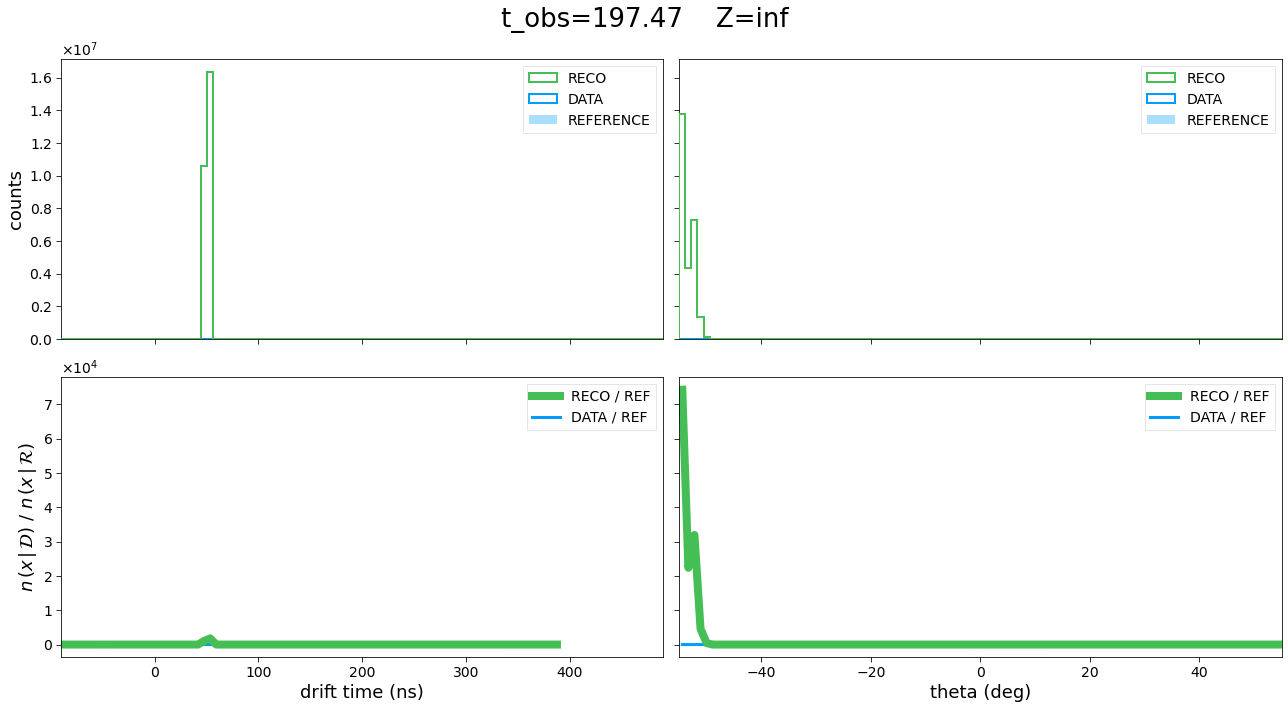

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


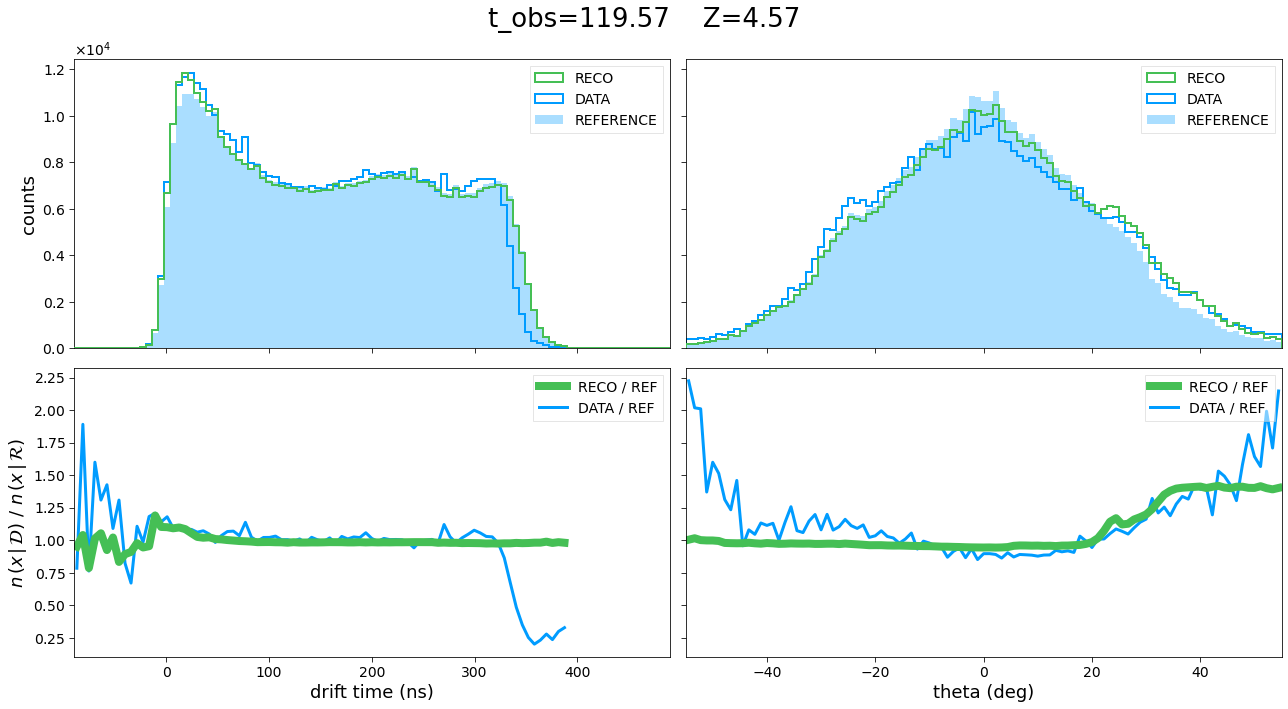

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


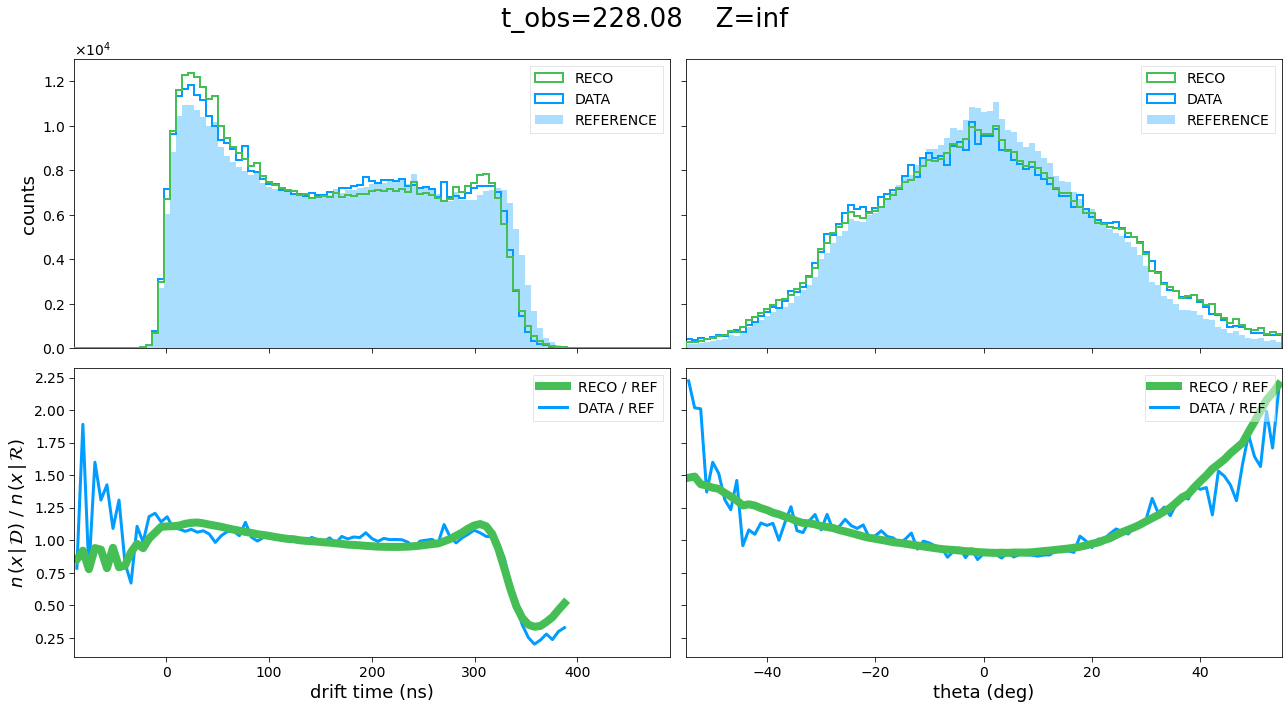

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


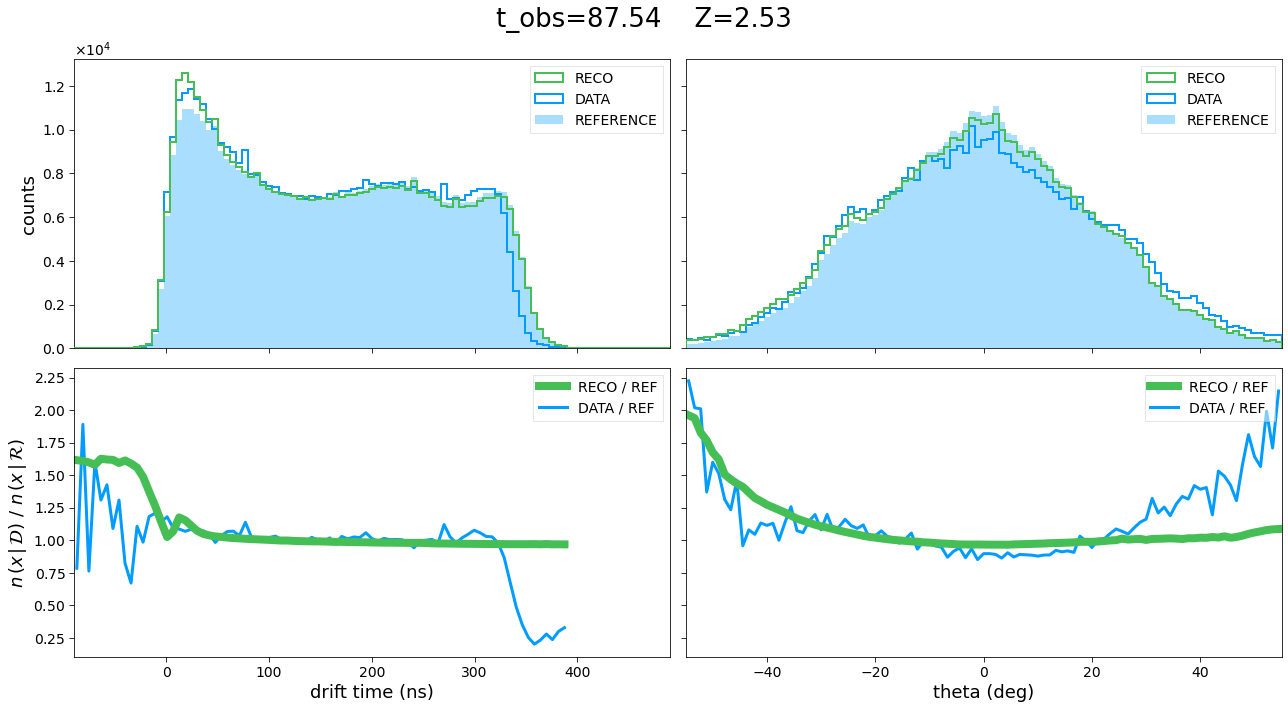

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


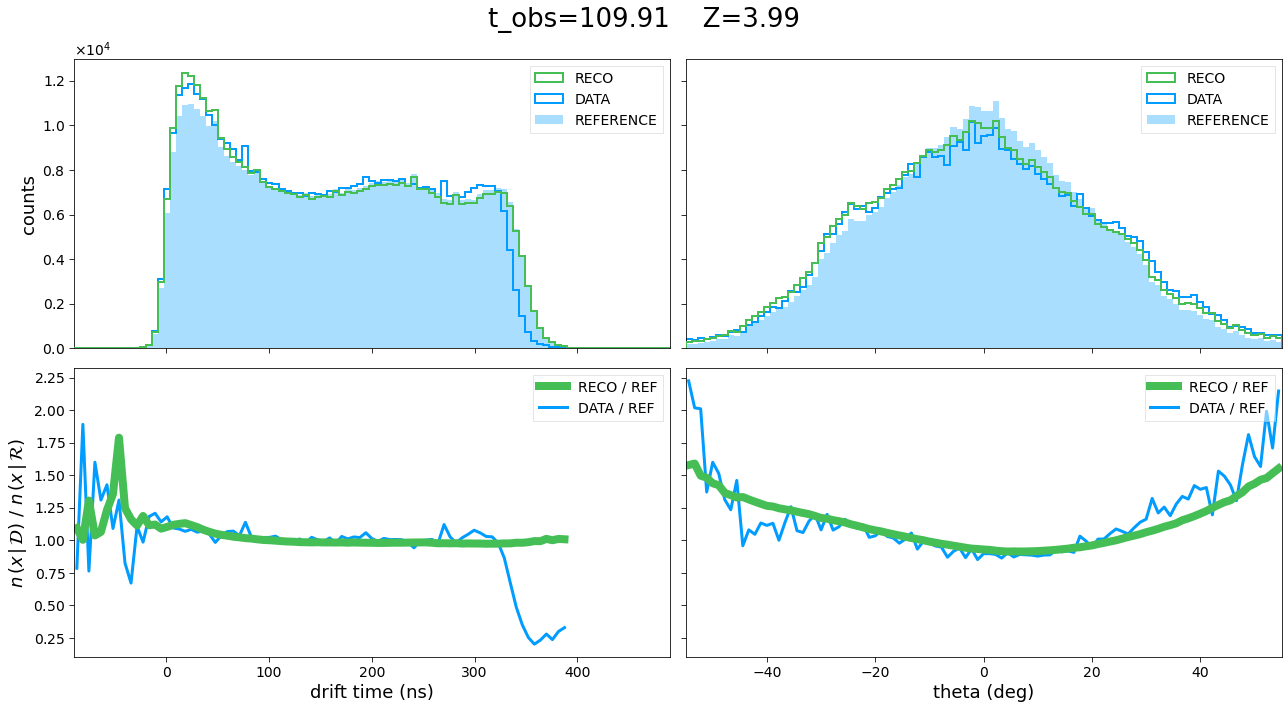

/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
/lustre/cmswork/nlai/lcp-moda/nplm/modules/analysis_utils.py:420: RuntimeWarning: invalid value encountered in true_divide


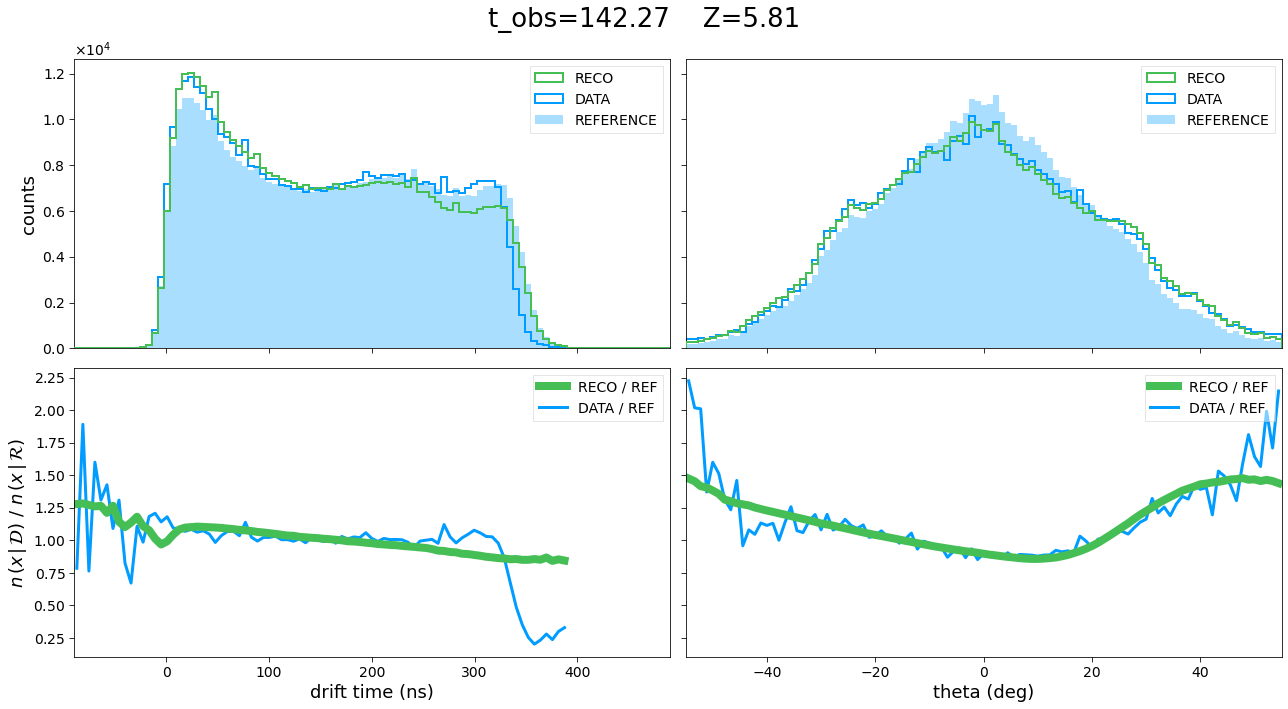

KeyboardInterrupt: 

In [61]:
for toy in range(tau.shape[0]):
    weights = [
        nn_par["dense_k"][toy],  nn_par["dense_b"][toy],
        nn_par["dense_1_k"][toy],nn_par["dense_1_b"][toy],
        nn_par["dense_2_k"][toy],nn_par["dense_2_b"][toy],
        nn_par["dense_3_k"][toy],nn_par["dense_3_b"][toy]
    ]
    
    model.layers[0].set_weights(weights)
    
    tau_ref = model.predict(reference)
    
    modules.analysis_utils.plot_reco(
        df          = dof,
        data        = data,
        weight_data = weightsData,
        ref         = reference,
        weight_ref  = weightsRef,
        tau_obs     = tau[toy],
        tau_ref     = tau_ref,
        features    = FEATURES,
        bins_code   = bins_code,
        xlabel_code = xlabel_code
    )